# Ornella Elena Grassi, Giulio Nenna
## Politecnico di Torino, A.Y. 2022/2023

## Introduction

The aim of this homework is to apply the Principal Component Analysis to a dataset which collects instances from the Online Motorcycle Catalog (bikez.com) updated to April 30, 2022.
The data .....
######## TODO say something about the dataset


## Preparation (Setting the Random State)
To start our analysis let's import the useful packages and set our plot parameters.
Additionally, we'll set the *random seed* as *rs = min{290310, ???}*, the minimum between our student IDs. It'll be used as the seed for random computations throughout the full analysis.

In [2]:
#%matplotlib notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from IPython.display import display

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 200

#some parameters set to make graphs nicer
plt.style.use('default')
# plt.rcParams['axes.facecolor'] = 'none'
#plt.rcParams['axes.grid'] = True
# plt.rcParams['figure.frameon'] = True

plt.rcParams['grid.color'] = '#000000'

#setting random seed
rs = 290310
np.random.seed(rs)

## Exercise 1 (Loading and Preparing the Data)
### Section (a), (b)
The dataframe is loaded and saved as a pandas DataFrame. Then, an amount of $\approx 1/3 $ of the DF is selected and saved in the sub-DF *workdf*.

In [3]:
df_path = 'data\cla4lsp22_bikez_curated.csv'
df_tot = pd.read_csv(df_path)
print(f'Original DataFrame dimensions: {df_tot.shape}')

r = np.random.randint(0,3)
workdf = df_tot.loc[df_tot['Year']%3 == r]

Original DataFrame dimensions: (38472, 27)


### Section (c)
The following code snippet divides our columns into *labels* and *features* and then chooses two random features to remove among the following: *Front/Rear brakes, Front/Rear tire, Front/suspension*. Lastly, it shows the resulting dataframe.

In [4]:
labels = workdf.iloc[:, :5].columns.tolist()
features = workdf.iloc[:, 5:].columns.tolist()

features_to_remove = ['Front brakes', 'Rear brakes', 'Front tire', 'Rear tire', 'Front suspension', 'Rear suspension']

features_to_remove = np.random.choice(features_to_remove, size=2, replace = False)

workdf.drop(columns=features_to_remove, axis = 1, inplace=True)
features = [x for x in features if x not in features_to_remove]

print(f'Columns {features_to_remove} have been dropped from the DF')
print(f'Updated dimensions: {workdf.shape}')
display(workdf)

Columns ['Rear tire' 'Front suspension'] have been dropped from the DF
Updated dimensions: (13673, 25)


Brand                   Model  Year                   Category   
1      acabion                 gtbo 55  2007                      Sport  \
4      acabion                 gtbo 70  2007  Prototype / concept model   
6       access     ams 3.20 supercross  2016                        ATV   
7       access  ams 4.30 supermoto efi  2016                        ATV   
8       access  ams 4.38 sm gear shift  2016                        ATV   
...        ...                     ...   ...                        ...   
38459  zündapp            roller super  1968                    Scooter   
38462  zündapp                   z 2 g  1923                      Sport   
38466  zündapp                    z 22  1923                      Sport   
38468  zündapp                   z 249  1923                      Sport   
38471  zündapp                   z 300  1929                      Sport   

       Rating  Displacement (ccm)  Power (hp)  Torque (Nm)  Engine cylinder   
1         2.6              1300.0       541.0        420.0     In-line four  \
4         3.1              1300.0       689.0        490.0     In-line four   
6         NaN               280.0        18.8          NaN  Single cylinder   
7         NaN               359.3        29.5          NaN  Single cylinder   
8         NaN               449.0        37.6          NaN  Single cylinder   
...       ...                 ...         ...          ...              ...   
38459     NaN                49.0         NaN          NaN  Single cylinder   
38462     NaN               211.0         2.8          NaN  Single cylinder   
38466     NaN               211.0         2.3          NaN  Single cylinder   
38468     NaN               249.0         2.8          NaN  Single cylinder   
38471     NaN               298.0        26.0          NaN  Single cylinder   

      Engine stroke            Gearbox  Bore (mm)  Stroke (mm)   
1       four-stroke            6-speed       81.0         63.0  \
4       four-stroke            6-speed       81.0         63.0   
6       four-stroke          Automatic        NaN          NaN   
7       four-stroke          Automatic        NaN          NaN   
8       four-stroke            5-speed        NaN          NaN   
...             ...                ...        ...          ...   
38459    two-stroke  Not Given/Unknown       39.0         42.0   
38462    two-stroke            2-speed       62.0         70.0   
38466    two-stroke  Not Given/Unknown       62.0         70.0   
38468    two-stroke            3-speed       68.0         82.5   
38471    two-stroke  Not Given/Unknown       68.0         82.5   

       Fuel capacity (lts)           Fuel control Cooling system   
1                      NaN      Not Given/Unknown         Liquid  \
4                      NaN      Not Given/Unknown         Liquid   
6                     14.0  Overhead Valves (OHV)            Air   
7                     14.0    Overhead Cams (OHC)            Air   
8                     14.0    Overhead Cams (OHC)            Air   
...                    ...                    ...            ...   
38459                  NaN      Not Given/Unknown            Air   
38462                  6.0      Not Given/Unknown            Air   
38466                  6.0      Not Given/Unknown            Air   
38468                  6.1      Not Given/Unknown            Air   
38471                  NaN  Overhead Valves (OHV)            Air   

       Transmission type  Dry weight (kg)  Wheelbase (mm)  Seat height (mm)   
1      Not Given/Unknown            360.0             NaN               NaN  \
4      Not Given/Unknown            300.0             NaN               NaN   
6                  Chain            225.0             NaN               NaN   
7                  Chain            236.0             NaN               NaN   
8                  Chain            236.0             NaN               NaN   
...                  ...              ...             ...               ...

#### Section (d)
##### Inspection of missing values
Now we perform an additional analysis that help us to inspect the nature of the missing values. In particular, we plot a histogram and a pie plot that show the amount of rows containing zero missing values, missing values for only categorical features or missing values for only numerical features, and rows containing both.
To do so, we create two dictionaries: the *categorical_columns* one has the name of the columns as keys and their possible categories as values; the dictionary *missing_count* contains the number of missing data for each feature. In addition, the array *missing* contains the number of missing values for each row.

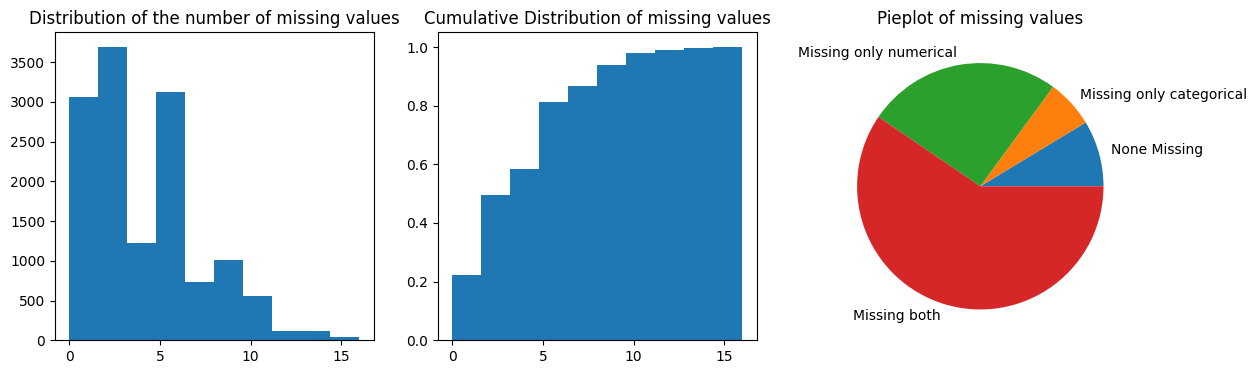

In [5]:
#CREATE USEFUL STRUCTURES TO PLOT THE DISTRIBUTION OF MISSING VALUES
categorical_columns = {}
missing_categorical = np.zeros(len(workdf))
missing_numerical = np.zeros(len(workdf))
missing_count = {}

for col in features:
    if workdf[col].dtype == 'O':  # if the feature is categorical
        workdf[col] = workdf[col].str.lower()  # avoid case-sensitive conflicts
        unique_values = workdf[col].unique()
        categorical_columns[col] = unique_values
        missing_categorical += (workdf[col] == 'not given/unknown').astype(int)
        missing_count[col] = missing_categorical.sum()
    else:
        missing_numerical += workdf[col].isna().astype(int)
        missing_count[col] = missing_numerical.sum()

cat_col_names = list(categorical_columns.keys())
num_col_names = [col for col in features if col not in cat_col_names]

missing = missing_categorical + missing_numerical
missing_categorical_bool = missing_categorical.astype(bool)
missing_numerical_bool = missing_numerical.astype(bool)
none_missing = ~missing_numerical_bool & ~missing_categorical_bool
missing_only_categorical = missing_categorical_bool & ~missing_numerical_bool
missing_only_numerical = missing_numerical_bool & ~missing_categorical_bool
missing_both = missing_categorical_bool & missing_numerical_bool


#VISUAL REPRESENTATION
fig, axs= plt.subplots(1,3)
fig.set_size_inches(14,4)

#HISTOGRAM
axs[0].hist(missing)
axs[0].set_title('Distribution of the number of missing values')
axs[1].hist(missing, cumulative=True, density = True)
axs[1].set_title('Cumulative Distribution of missing values')

#PIEPLOT OF DF ROWS
pie_label = ['None Missing', 'Missing only categorical', 'Missing only numerical', 'Missing both']
pie_data = [none_missing.sum(), missing_only_categorical.sum(), missing_only_numerical.sum(), missing_both.sum()]
axs[2].pie(pie_data, labels = pie_label)
axs[2].set_title('Pieplot of missing values')
plt.grid(linewidth = 1)
plt.show()

##### Analysis of missing values over the rows
The code section below shows that $\approx 90 \% $ of the rows in our dataframe has at least one missing value per row. Removing all of them would be unacceptable for our analysis, since it would cut out the majority of our observations. Therefore, we decide to remove rows with more than *4* missing data (i.e. the $ 20 \% $ of the features) resulting in a reduction of the $\approx 42\%$ of the dataframe.

In [6]:
#COUNT MISSING VALUES FOR EACH ROW
count_one = np.count_nonzero(missing > 0)
print(f'Rows with at least one missing value: {count_one} out of {len(workdf)}, i.e. {round(count_one / len(workdf)*100, 2) } %.'  )

rows_to_remove = missing[missing > 4]
count_five = len(rows_to_remove)
print(f'Rows with at least five missing values: {count_five} out of {len(workdf)}, i.e. {round(count_five / len(workdf)*100, 2) } %.' )

Rows with at least one missing value: 12489 out of 13673, i.e. 91.34 %.
Rows with at least five missing values: 5699 out of 13673, i.e. 41.68 %.


In [7]:
#REMOVE SELECTED ROWS
mask = workdf.index.isin(rows_to_remove.index)
workdf = workdf[~mask]

#UPDATE USEFUL STRUCTURES
missing = missing.drop(rows_to_remove.index)
workdf.replace("not given/unknown", pd.NA, inplace=True)            # Categorical missing values are labeled "not giving/unknown"
missing_count = {}
for col in features:
    missing_count[col] = workdf[col].isna().sum()

#PRINT RESULTS
print(f'Updated DF dimensions: {workdf.shape}')
print(f'There are {(workdf.iloc[:, 5:].isnull().sum(axis=1) > 4).sum()} rows with more than 4 missing features')   # checks if we removed all entries with at least 5 mv for the columns "features"
#print(missing_count)
display(workdf)

Updated DF dimensions: (7974, 25)
There are 0 rows with more than 4 missing features


Brand                          Model  Year       Category  Rating   
37       adiva                       ad 125le  2010        Scooter     1.9  \
45       adiva                        ad3 300  2019        Scooter     NaN   
48       adiva                        ad3 400  2019        Scooter     NaN   
58       adiva                           n125  2010        Scooter     NaN   
88       adler                mbs 250 favorit  1959       Allround     NaN   
...        ...                            ...   ...            ...     ...   
38403  zündapp                          k 800  1938       Allround     NaN   
38423  zündapp  ks 50 super sport type 517-20  1971  Sport touring     3.7   
38428  zündapp                         ks 601  1950       Allround     NaN   
38431  zündapp                         ks 601  1953       Allround     3.9   
38468  zündapp                          z 249  1923          Sport     NaN   

       Displacement (ccm)  Power (hp)  Torque (Nm)      Engine cylinder   
37                  124.0        13.0         10.9      single cylinder  \
45                  299.0        29.4         31.0      single cylinder   
48                  399.0        36.7         38.1      single cylinder   
58                  124.0        10.3          9.8      single cylinder   
88                  250.0        16.0          NaN                 twin   
...                   ...         ...          ...                  ...   
38403               791.0        22.0          NaN  four cylinder boxer   
38423                50.0         6.0          NaN      single cylinder   
38428               592.0        28.0          NaN   two cylinder boxer   
38431               592.0        28.0          NaN   two cylinder boxer   
38468               249.0         2.8          NaN      single cylinder   

      Engine stroke    Gearbox  Bore (mm)  Stroke (mm)  Fuel capacity (lts)   
37      four-stroke  automatic       48.8         57.0                 13.5  \
45      four-stroke  automatic       72.7         72.0                 11.0   
48      four-stroke  automatic       84.0         72.0                 11.0   
58      four-stroke       <NA>       52.4         57.8                  6.0   
88       two-stroke    4-speed       54.0         54.0                 15.0   
...             ...        ...        ...          ...                  ...   
38403   four-stroke    4-speed       62.0         66.6                 12.5   
38423    two-stroke    5-speed       39.0         41.8                  9.7   
38428    two-stroke    4-speed       75.0         67.6                 14.5   
38431    two-stroke    4-speed       75.0         67.6                 14.5   
38468    two-stroke    3-speed       68.0         82.5                  6.1   

                      Fuel control Cooling system Transmission type   
37     single overhead cams (sohc)         liquid              belt  \
45     single overhead cams (sohc)         liquid              <NA>   
48     single overhead cams (sohc)         liquid              <NA>   
58     single overhead cams (sohc)           <NA>              <NA>   
88                            <NA>            air             chain   
...                            ...            ...               ...   
38403                         <NA>            air       shaft drive   
38423                 port control            air             chain   
38428        overhead valves (ohv)            air       shaft drive   
38431        overhead valves (ohv)            air       shaft drive   
38468                         <NA>            air              belt   

       Dry weight (kg)  Wheelbase (mm)  Seat height (mm)         Fuel system   
37               171.0          1640.0               NaN         carburettor  \
45               202.0          1560.0             700.0           injection   
48               257.0          1560.0             770.0           injection   
58               108.0          1320.0           

##### Analysis of missing values over the columns
The following bar plot shows the percentages of missing values for each feature. Firstly, we analyze the numerical features. The graph is highly informative, and allows us to draw some conclusions:
- **Torque (Nm)** has the most missing values among the numerical columns. To decide whether to keep it or not, we think that *Power (Hp)* may represent similar characteristics of a motorcycle. Thus, we print the correlation coefficient of *Torque(Nm)* and *Power (Hp)*. Being the latter $\approx 0.9$, we remove *Torque (Nm)* from the DF columns.
- **Dry weight (kg)** has a lot of missing values as well. Being it an indicator of a motorcycle dimensions, we think if removing it from our analysis could be a valid choice. We notice that there are other size indicators such as *Seat height (mm)* and *Wheelbase (mm)* which can do the same job, thus we plot the correlation coefficient between *Dry weight (kg)* and the latter two. Being too low to show a clear correlation we decide to keep the variable in our analysis and impute missing values by replacing them with the mean.

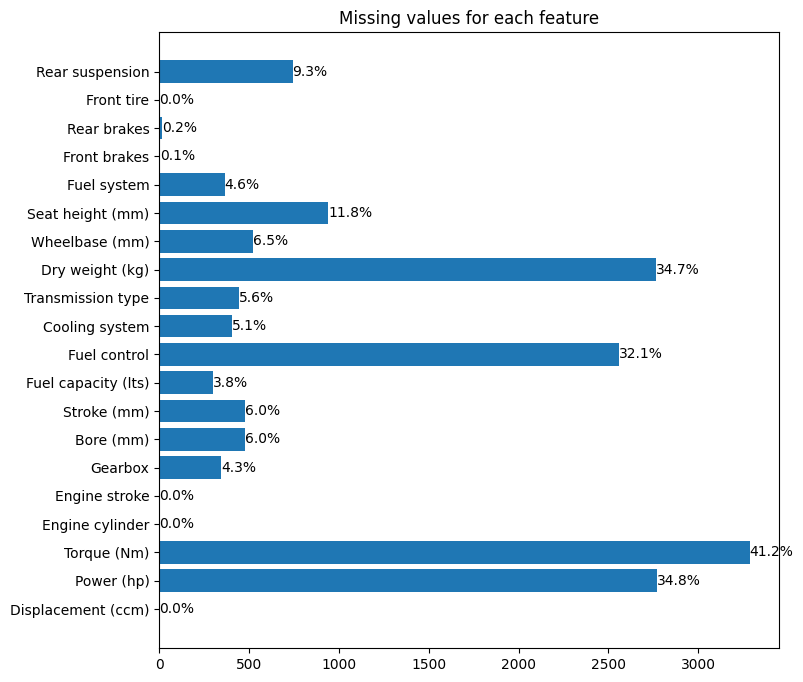

Torque (Nm) and Power (hp) correlation coefficient: 0.891
 Dry weight (kg) and Seat height (mm) correlation coefficient: -0.14
 Dry weight (kg) and Wheelbase (mm) correlation coefficient: 0.665
['Torque (Nm)'] has been deleted from the DataFrame


In [8]:
#BARPLOT: MISSING VALUES FOR EACH FEATURE
fig, ax = plt.subplots()
fig.set_size_inches(8, 8)
ax.barh(list(missing_count.keys()), missing_count.values())
ax.set_title('Missing values for each feature')

for i, (key, value) in enumerate(missing_count.items()):            # Add text labels to each bar
    perc = value / len(workdf)
    ax.text(value, i, f'{perc:.1%}', ha='left', va='center')
plt.show()

#ANALYZE TORQUE(Nm)
correlation1 = workdf['Torque (Nm)'].corr(workdf['Power (hp)'])
print(f'Torque (Nm) and Power (hp) correlation coefficient: {round(correlation1, 3)}')

#ANALYZE DRY WEIGHT(Kg)
correlation2 = workdf['Dry weight (kg)'].corr(workdf['Seat height (mm)'])
print(f' Dry weight (kg) and Seat height (mm) correlation coefficient: {round(correlation2, 3)}')
correlation3 = workdf['Dry weight (kg)'].corr(workdf['Wheelbase (mm)'])
print(f' Dry weight (kg) and Wheelbase (mm) correlation coefficient: {round(correlation3, 3)}')

#REMOVE FEATURES
workdf.drop('Torque (Nm)', axis=1, inplace=True)

#REMOVE FROM COLUMN NAMES LISTS
features_to_remove = ['Torque (Nm)']
features = [x for x in features if x not in features_to_remove]
num_col_names = [x for x in num_col_names if x not in features_to_remove]

#PRINT RESULTS
print(f'{features_to_remove} has been deleted from the DataFrame')

Secondly, we analyze the categorical columns. From the graph above we can notice that few features have barely $0.0\%$ of missing values. Thus, we analyze each of the other columns by plotting a histogram of their occurrences, in order to decide how to treat missing values.

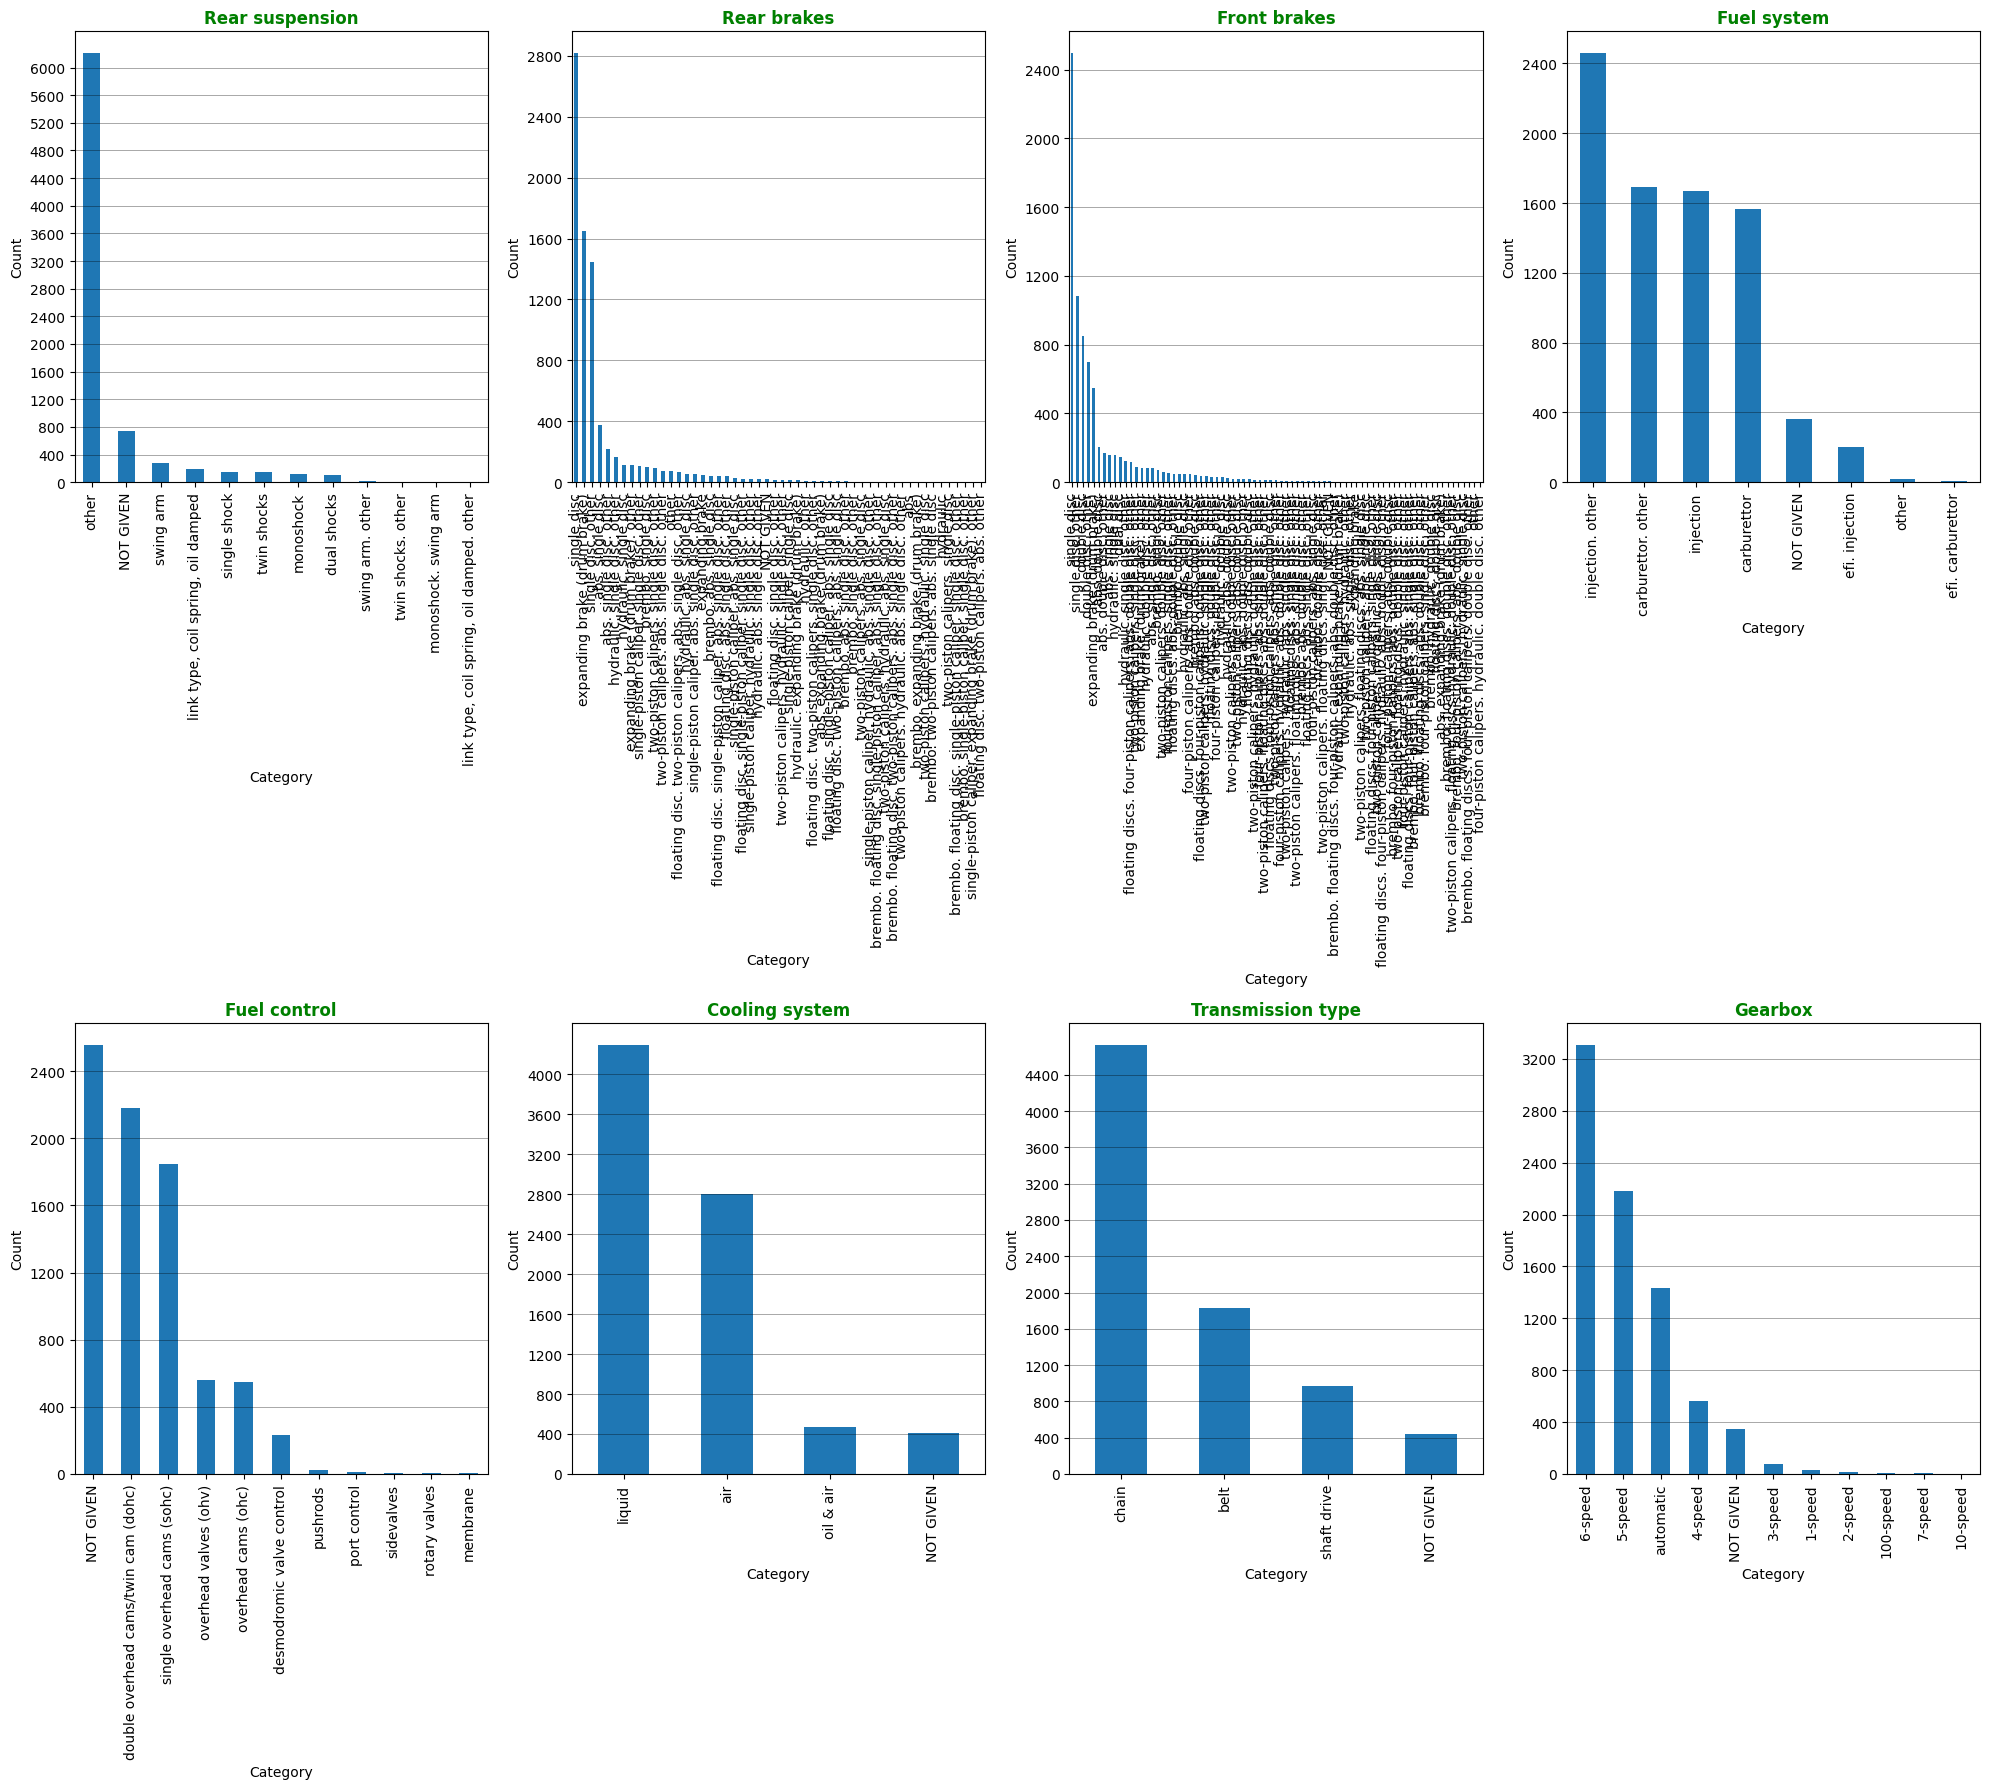

In [9]:
#PLOT A HISTOGRAM OF THE CHOSEN COLUMNS
cat_to_inspect = ['Rear suspension', 'Rear brakes', 'Front brakes', 'Fuel system', 'Fuel control', 'Cooling system', 'Transmission type', 'Gearbox']

n_rows = 2
n_cols = 4
n_plots = n_rows * n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 18))

for i, col in enumerate(cat_to_inspect):
    r = i //n_cols
    c = i %n_cols
    ax = axes[r, c]

    #Plot the histogram for the current column
    hist = workdf[col].value_counts(dropna=False).plot(kind='bar', ax=ax)
    #Customize each plot
    yticks = np.arange(0, max(workdf[col].value_counts(dropna=False))+10, 400)
    ax.set_title(col, color = 'green', fontweight = 'bold')  # set title using axis object
    ax.set_xlabel('Category')                                # set x-label using axis object
    ax.set_ylabel('Count')                                   # set y-label using axis object
    ax.set_yticks(yticks)
    ax.grid(True, axis='y', linewidth=0.4, alpha = 0.6)  # add grid lines

    # modify x-axis tick labels
    tick_labels = ax.get_xticklabels()
    new_tick_labels = [label.get_text().replace('<NA>', 'NOT GIVEN') for label in tick_labels]
    ax.set_xticklabels(new_tick_labels)

plt.tight_layout()
plt.show()

The graphs above give interesting information about the columns analyzed. Specifically:
- **Rear suspension** has the majority of the data which are: *other* or *NOT GIVEN* (missing). Thus, we decide to drop the entire column: keeping it into our dataset would increase the complexity of the analysis without giving a valuable contribute.
- **Rear brakes** and **Front brakes** have a ton of categories, the most of these having very low frequency in our observations. In addition, they have very similar values, representing both the brakes used in the motorcycles. Therefore, since an encoding such as one-hot encoding would only exponentially increase the dimensionality of our dataset, we delete **Front brakes** from our PCA, so as to reduce complexity.
- **Fuel control** has the $32.1\%$ of data *NOT GIVEN*. Moreover, the remaining $ \approx 68\% $ of data are distributed heterogeneously among 14 categories, which are poorly interpretable and meaningless for our PCA, in our point of view. Therefore, we remove this column from our dataframe, too.
- **Transmission type** and **Fuel system** are very interesting categories. We decide to keep missing values as a separate instance, combining it with the category *"other"*, when possible.
- In **Cooling system** and **Gearbox**, along with the not-plotted-here categories **Front tire**, **Engine stroke**, **Engine cylinder** (with $\approx 0\%$ of missing values) we will replace the *NOT GIVEN* values with the mode of the column.

###### TODO: ricordati che fuel control è molto correlato con Engine stroke, hanno lo stesso significato praticamente (vedi se scriverlo o meno)

In [10]:
#REMOVE THE REDUNDANT FEATURES
features_to_remove = ['Rear suspension', 'Front brakes', 'Fuel control']

workdf.drop(columns=features_to_remove, axis=1, inplace=True)

#UPDATE USEFUL STRUCTURES
features = [x for x in features if x not in features_to_remove]             #a list with all column names
cat_col_names = [x for x in cat_col_names if x not in features_to_remove]   #a list with the names of categorical columns
for f in features_to_remove:                                                #the dictionary we use for encoding
    if f in categorical_columns:
        del categorical_columns[f]

#PRINT RESULTS
print("Updated DF dimensions: ", workdf.shape)
workdf.head(10)

Updated DF dimensions:  (7974, 21)


Brand             Model  Year         Category  Rating   
37   adiva          ad 125le  2010          Scooter     1.9  \
45   adiva           ad3 300  2019          Scooter     NaN   
48   adiva           ad3 400  2019          Scooter     NaN   
58   adiva              n125  2010          Scooter     NaN   
88   adler   mbs 250 favorit  1959         Allround     NaN   
129   adly       panther 100  2007          Scooter     NaN   
138   adly  rt 50 roadtracer  2010  Minibike, sport     NaN   
146   adly  sf-50 silver fox  2010          Scooter     3.4   
170   aeon            3d-350  2019          Scooter     NaN   
171   aeon          3d-350 r  2019          Scooter     NaN   

     Displacement (ccm)  Power (hp)  Engine cylinder Engine stroke    Gearbox   
37                124.0        13.0  single cylinder   four-stroke  automatic  \
45                299.0        29.4  single cylinder   four-stroke  automatic   
48                399.0        36.7  single cylinder   four-stroke  automatic   
58                124.0        10.3  single cylinder   four-stroke       <NA>   
88                250.0        16.0             twin    two-stroke    4-speed   
129                95.6         NaN  single cylinder    two-stroke  automatic   
138                49.3         NaN  single cylinder    two-stroke  automatic   
146                49.3         3.7  single cylinder    two-stroke  automatic   
170               346.0        27.0  single cylinder   four-stroke  automatic   
171               346.0        30.0  single cylinder   four-stroke  automatic   

     Bore (mm)  Stroke (mm)  Fuel capacity (lts) Cooling system   
37        48.8         57.0                 13.5         liquid  \
45        72.7         72.0                 11.0         liquid   
48        84.0         72.0                 11.0         liquid   
58        52.4         57.8                  6.0           <NA>   
88        54.0         54.0                 15.0            air   
129       52.0         45.0                  6.2            air   
138       40.0         39.2                  6.2            air   
146       40.0         39.2                  NaN            air   
170       82.0         65.5                 13.5         liquid   
171       82.0         65.5                 13.5         liquid   

    Transmission type  Dry weight (kg)  Wheelbase (mm)  Seat height (mm)   
37               belt            171.0          1640.0               NaN  \
45               <NA>            202.0          1560.0             700.0   
48               <NA>            257.0          1560.0             770.0   
58               <NA>            108.0          1320.0             800.0   
88              chain            165.0             NaN               NaN   
129              <NA>             83.0          1240.0             815.0   
138              belt             75.0          1046.0               NaN   
146              belt             76.0          1220.0               NaN   
170             chain            212.5          1565.0             790.0   
171             chain            224.0          1565.0             790.0   

            Fuel system                    Rear brakes Front tire  
37          carburettor                    single disc      other  
45            injection                    single disc      other  
48            injection                    single disc      other  
58          carburettor   expanding brake (drum brake)  120/70-12  
88          carburettor   expanding brake (drum brake)      other  
129  carburettor. other   expanding brake (drum brake)  120/70-12  
138         carburettor   expanding brake (drum brake)      other  
146         carburettor   expanding brake (drum brake)      other  
170      efi. injection  hydraulic. single disc. other      other  
171      efi. injection  hydraulic. single disc. other      other

In [11]:
#DEAL WITH REMAINING MISSING VALUES
# Replace with mode (categorical), with mean (numerical), or remark as another category (other) the remaining columns.
cat_to_replace = ['Engine cylinder', 'Engine stroke', 'Front tire','Cooling system', 'Gearbox']
cat_to_fill = ['Transmission type', 'Fuel system', 'Rear brakes']

for col in cat_to_replace:                              #replace with the mode
     mode = min(workdf[col].mode())
     workdf[col]= workdf[col].fillna(value = mode)

for col in cat_to_fill:                                 #fill with 'other'
    workdf[col] = workdf[col].fillna('other')

for col in num_col_names:                               #replace with the mean
    col_mean = round(workdf[col].mean(),2)
    workdf[col]=workdf[col].fillna(value = col_mean)

rating_mean = round(workdf['Rating'].mean(), 1)
workdf['Rating'] = workdf['Rating'].fillna(value = rating_mean)

workdf.head(10)

Brand             Model  Year         Category  Rating   
37   adiva          ad 125le  2010          Scooter     1.9  \
45   adiva           ad3 300  2019          Scooter     3.4   
48   adiva           ad3 400  2019          Scooter     3.4   
58   adiva              n125  2010          Scooter     3.4   
88   adler   mbs 250 favorit  1959         Allround     3.4   
129   adly       panther 100  2007          Scooter     3.4   
138   adly  rt 50 roadtracer  2010  Minibike, sport     3.4   
146   adly  sf-50 silver fox  2010          Scooter     3.4   
170   aeon            3d-350  2019          Scooter     3.4   
171   aeon          3d-350 r  2019          Scooter     3.4   

     Displacement (ccm)  Power (hp)  Engine cylinder Engine stroke    Gearbox   
37                124.0       13.00  single cylinder   four-stroke  automatic  \
45                299.0       29.40  single cylinder   four-stroke  automatic   
48                399.0       36.70  single cylinder   four-stroke  automatic   
58                124.0       10.30  single cylinder   four-stroke    6-speed   
88                250.0       16.00             twin    two-stroke    4-speed   
129                95.6       59.51  single cylinder    two-stroke  automatic   
138                49.3       59.51  single cylinder    two-stroke  automatic   
146                49.3        3.70  single cylinder    two-stroke  automatic   
170               346.0       27.00  single cylinder   four-stroke  automatic   
171               346.0       30.00  single cylinder   four-stroke  automatic   

     Bore (mm)  Stroke (mm)  Fuel capacity (lts) Cooling system   
37        48.8         57.0                13.50         liquid  \
45        72.7         72.0                11.00         liquid   
48        84.0         72.0                11.00         liquid   
58        52.4         57.8                 6.00         liquid   
88        54.0         54.0                15.00            air   
129       52.0         45.0                 6.20            air   
138       40.0         39.2                 6.20            air   
146       40.0         39.2                13.11            air   
170       82.0         65.5                13.50         liquid   
171       82.0         65.5                13.50         liquid   

    Transmission type  Dry weight (kg)  Wheelbase (mm)  Seat height (mm)   
37               belt            171.0          1640.0            795.26  \
45              other            202.0          1560.0            700.00   
48              other            257.0          1560.0            770.00   
58              other            108.0          1320.0            800.00   
88              chain            165.0          1430.6            795.26   
129             other             83.0          1240.0            815.00   
138              belt             75.0          1046.0            795.26   
146              belt             76.0          1220.0            795.26   
170             chain            212.5          1565.0            790.00   
171             chain            224.0          1565.0            790.00   

            Fuel system                    Rear brakes Front tire  
37          carburettor                    single disc      other  
45            injection                    single disc      other  
48            injection                    single disc      other  
58          carburettor   expanding brake (drum brake)  120/70-12  
88          carburettor   expanding brake (drum brake)      other  
129  carburettor. other   expanding brake (drum brake)  120/70-12  
138         carburettor   expanding brake (drum brake)      other  
146         carburettor   expanding brake (drum brake)      other  
170      efi. injection  hydraulic. single disc. other      other  
171      efi. injection  hydraulic. single disc. other      other

## Exercise 2 (Encoding of Categorical Data)
### Section (a)
This section aims to perform a proper encoding of categorical features. To do so, we'll print the categories of each column in order to decide which columns need special encoding. Moreover, we'll assign a color to each column before encoding is computed. This will help us to visualize PCA results and to represent the special encoded columns with a reference to their original category.


In [12]:
#UPDATE DICTIONARY AFTER MV HANDLING
for col in cat_col_names:
    categorical_columns[col] = workdf[col].unique() #append its unique values into a dict entry

#VISUALIZE CATEGORIES FOR EACH FEATURE
for col, unique_values in categorical_columns.items():
    print(f"Column '{col}' has {len(unique_values)} categories:")
    for i, val in enumerate(unique_values):
        print(f"   {i+1}. {val}")

Column 'Engine cylinder' has 14 categories:
   1. single cylinder
   2. twin
   3. v2
   4. four cylinder boxer
   5. v4
   6. diesel
   7. square four cylinder
   8. v8
   9. in-line four
   10. in-line three
   11. two cylinder boxer
   12. in-line six
   13. v6
   14. six cylinder boxer
Column 'Engine stroke' has 4 categories:
   1.  four-stroke
   2.  two-stroke
   3. diesel
   4. square four cylinder
Column 'Gearbox' has 10 categories:
   1. automatic
   2. 6-speed
   3. 4-speed
   4. 1-speed
   5. 5-speed
   6. 3-speed
   7. 2-speed
   8. 10-speed
   9. 7-speed
   10. 100-speed
Column 'Cooling system' has 3 categories:
   1. liquid
   2. air
   3. oil & air
Column 'Transmission type' has 4 categories:
   1. belt
   2. other
   3. chain
   4. shaft drive
Column 'Fuel system' has 7 categories:
   1. carburettor
   2. injection
   3. carburettor. other
   4. efi. injection
   5. efi. carburettor
   6. injection. other
   7. other
Column 'Rear brakes' has 51 categories:
   1. single 

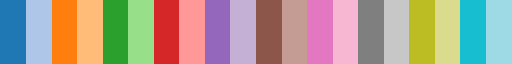

In [13]:
#DEFINE COLORS FOR EACH FEATURE BEFORE CATEGORICAL ENCODING
num_features = len(features)

#define colormap and get the colors
colors = cm.tab20.colors
feature_colors = colors[:num_features]

#create a dictionary: Feature -> color
general_feature_colors = {}
for i in range(num_features):
    general_feature_colors[workdf.iloc[:, 5:].columns[i]] = feature_colors[i]


# SHOWING THE COLORS OF THE CHOSEN COLORMAP
display(cm.tab20)

The only feature needing special encoding $\alpha . \beta \dots$ is **Fuel system**. We perform it using *MultiLabelBinarizer* from the sklearn.preprocessing library.
###### TODO: controlla rear e front brakes che ho tolto del tutto
Then, we notice that among the remaining features there's one possible candidate to be encoded with label encoding, which is **Gearbox**. In fact, its values are: $ \{ 1,2,...7\}$*-speed*, *10-speed*, *100-speed* and *automatic*. Since these values are somehow incremental, we prefer to use a *label_encoding* because it is a good trade-off between not-augmenting the dimensionality of the dataframe and generating an implicit order of the labes. Thus, a dictionary of values from 1 to 10 is created and saved into the *workdf_encoded* object.
 The other features, however, are not treatable in the same way. *One-hot encoding* is preferred because it avoids an inherent ordering of categories.
 The results are temporarily stored in the *workdf_encoded* dataframe.

###### **TODO: cambiare la didascalia perchè alla fine ho fatto un altra cosa**


In [14]:
#CREATE ANOTHER DATAFRAME TO SAVE THE RESULTS
workdf_encoded = workdf.iloc[:, :5]
print(workdf_encoded)
special_enc_col = ['Fuel system', 'Rear brakes']
label_enc_col = ['Gearbox']
for col in cat_col_names:
    #special encoding
    if col in special_enc_col:
        workdf[col]=[entry.split(sep='. ') for entry in workdf[col]]        #split every entry into list of categories
        mlb = MultiLabelBinarizer(sparse_output=True)                       #initialize a multilabel-binarizer
        mlb_df = pd.DataFrame.sparse.from_spmatrix(mlb.fit_transform(workdf[col]),                      #perform the multilabel encoding
                                                   index = workdf_encoded.index,
                                                   columns=[col + '_' + c for c in mlb.classes_])       #generate a dataframe from the encoding
        general_feature = col.split('_')[0]
        new_cols = [col + '_' + c for c in mlb.classes_]
        color = general_feature_colors[general_feature]
        for new_col in new_cols:
            general_feature_colors[new_col] = color         #assign a color to the original column

        workdf_encoded=workdf_encoded.join(mlb_df)          #join the mlb dataframe with the final df

    # #label encoding
    # elif col in label_enc_col:
    #     Gearbox_dict = {
    #         '1-speed': 1.0,
    #         '2-speed': 2.0,
    #         '3-speed': 3.0,
    #         '4-speed': 4.0,
    #         '5-speed': 5.0,
    #         '6-speed': 6.0,
    #         '7-speed': 7.0,
    #         '10-speed': 8.0,
    #         '100-speed': 9.0,
    #        'automatic' : 10.0,
    #     }
    #     # Change column Gearbox in the workdf_encoded df using the new encoding
    #     # Create a new column with the encoded values
    #     encoded_gearbox = workdf[col].map(Gearbox_dict)
    #     workdf_encoded = workdf_encoded.join(encoded_gearbox)

    #one-hot encoding
    else:
        workdf_encoded = workdf_encoded.join(pd.get_dummies(workdf[col], prefix=col))   #join the result one-hot df with the final df

# add numerical features (no encoding needed)
for col in num_col_names:
    workdf_encoded = workdf_encoded.join(workdf[col])

         Brand                          Model  Year       Category  Rating
37       adiva                       ad 125le  2010        Scooter     1.9
45       adiva                        ad3 300  2019        Scooter     3.4
48       adiva                        ad3 400  2019        Scooter     3.4
58       adiva                           n125  2010        Scooter     3.4
88       adler                mbs 250 favorit  1959       Allround     3.4
...        ...                            ...   ...            ...     ...
38403  zündapp                          k 800  1938       Allround     3.4
38423  zündapp  ks 50 super sport type 517-20  1971  Sport touring     3.7
38428  zündapp                         ks 601  1950       Allround     3.4
38431  zündapp                         ks 601  1953       Allround     3.9
38468  zündapp                          z 249  1923          Sport     3.4

[7974 rows x 5 columns]


### Section (b)
The resulting DF is saved here in the variable *XworkDF*, as requested. The labels, hence the columns from 1 to 5, are instead saved into *LabelsDF* for further usage.

In [15]:
XworkDF = workdf_encoded.iloc[:, 5:]
LabelsDF = workdf_encoded.iloc[:, :5]
print("Updated DF dimensions: ", XworkDF.shape, "\nThe resulting features are: \n", XworkDF.columns)

Updated DF dimensions:  (7974, 67) 
The resulting features are: 
 Index(['Engine cylinder_diesel', 'Engine cylinder_four cylinder boxer',
       'Engine cylinder_in-line four', 'Engine cylinder_in-line six',
       'Engine cylinder_in-line three', 'Engine cylinder_single cylinder',
       'Engine cylinder_six cylinder boxer',
       'Engine cylinder_square four cylinder', 'Engine cylinder_twin',
       'Engine cylinder_two cylinder boxer', 'Engine cylinder_v2',
       'Engine cylinder_v4', 'Engine cylinder_v6', 'Engine cylinder_v8',
       'Engine stroke_ four-stroke', 'Engine stroke_ two-stroke',
       'Engine stroke_diesel', 'Engine stroke_square four cylinder',
       'Gearbox_1-speed', 'Gearbox_10-speed', 'Gearbox_100-speed',
       'Gearbox_2-speed', 'Gearbox_3-speed', 'Gearbox_4-speed',
       'Gearbox_5-speed', 'Gearbox_6-speed', 'Gearbox_7-speed',
       'Gearbox_automatic', 'Cooling system_air', 'Cooling system_liquid',
       'Cooling system_oil & air', 'Transmission type_be

## Exercise 3 (Preprocessing and PCA)
### Section (a)
The following code snippet creates the requested dataframes, used to scale data. In *Xworkdf_std* we use StandardScaler while *Xworkdf_mm* contains data scaled with MinMaxScaler.

In [16]:
data_mat = XworkDF.to_numpy()

#STANDARD SCALE
scaler_std = StandardScaler()
Xworkdf_std = pd.DataFrame(scaler_std.fit_transform(data_mat), index=XworkDF.index, columns=XworkDF.columns)

#MIN-MAX SCALE
scaler_mm = MinMaxScaler()
Xworkdf_mm = pd.DataFrame(scaler_mm.fit_transform(data_mat), index=XworkDF.index, columns=XworkDF.columns)


### Section (b)

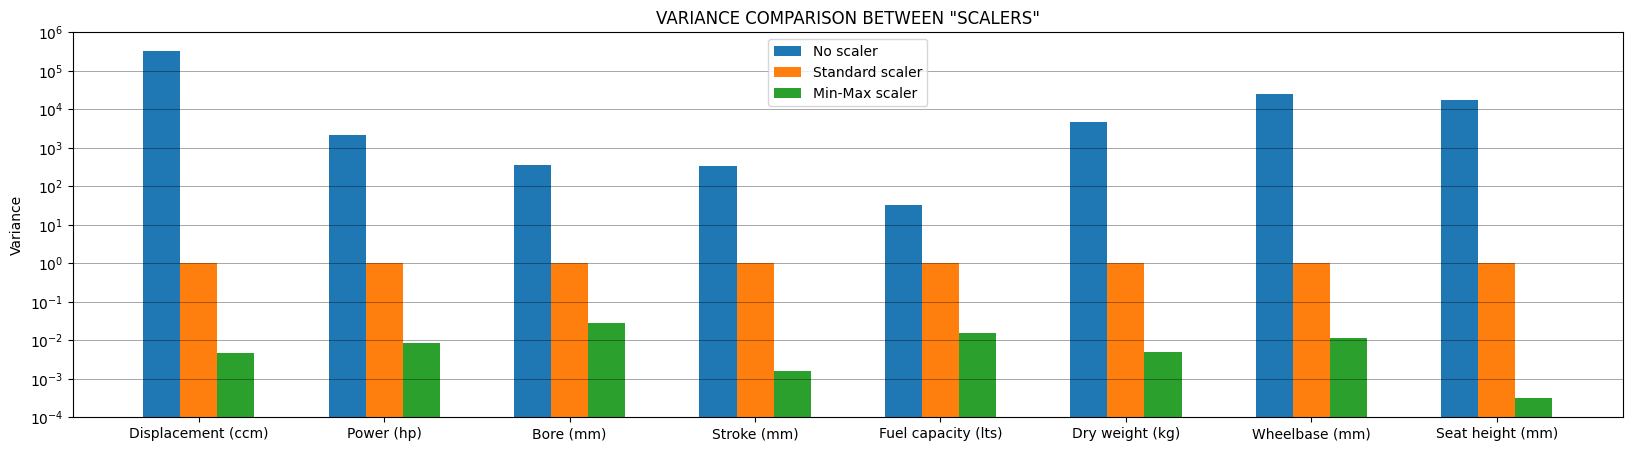

In [17]:
#VARIANCE COMPUTATION
var_numerical = np.array(XworkDF[num_col_names].var())
var_numerical_mm = np.array(Xworkdf_mm[num_col_names].var())
var_numerical_std = np.array(Xworkdf_std[num_col_names].var())

#VISUALIZE RESULTS
fig, ax = plt.subplots()
fig.set_size_inches(20, 5)
labels = [l for l in num_col_names]
X_axis = np.arange(len(num_col_names))
bar1 = ax.bar(X_axis-0.2, var_numerical, 0.2, label = 'No scaler')
bar2 = ax.bar(X_axis, var_numerical_std, 0.2, label = 'Standard scaler')
bar3 = ax.bar(X_axis+0.2, var_numerical_mm, 0.2, label = 'Min-Max scaler')

ax.set_ylabel('Variance')
ax.set_yscale('log')
ax.set_title('VARIANCE COMPARISON BETWEEN "SCALERS"')
#ax.set_xlabel('Numerical features')
ax.set_xticks(X_axis)
ax.set_yticks(ticks= np.logspace(-4, 6, 11))
ax.set_xticklabels(labels)
ax.grid(axis='y', linewidth=0.6, alpha = 0.4)
ax.legend()
plt.show()

The bar plot above represents the **variance** explained by numerical features in the three different dataframes (original, standardized and min-max scaled i.e. normalized), showing the impact of the scaling techniques on the distribution and range of the data.
1. **Original Dataframe**: the variances of the numerical features reflect the original distribution and spread of the data. The largest interval of data is the one of **Displacement (ccm)**, with values in $ [250, 82770] $, its distribution having a variance of over $10^5$. Of course, PCA cannot give significant results on it, but it serves as a baseline for comparison.
2. **Standard Scaled Dataframe**: the variances are relatively more balanced and similar across different features. Standard scaling helps to center the data around zero with a standard deviation of 1, resulting in features that equally contribute to the analysis. As we can notice each feature's distribution has a variance of $1$.
3. **Min-Max Scaled Dataframe**: it is obtained by normalizing values to a specific range, between a minimum value (m) and a maximum value (M) for each column. This normalization technique ensures that each feature is scaled to its own range, preventing any single feature from dominating the analysis due to a larger variance or range. However, it maintains the relative relationships between the values within each feature, which leads to variances of the features being of different order of magnitude, from $10^\(-4\)$ to $10^\(-2\)$.


### Section (c)
PCA is performed on the three dataframes. The full PCA takes into account  all the columns of our DFs and extracts the principal components obtained as a linear combination of the latter.

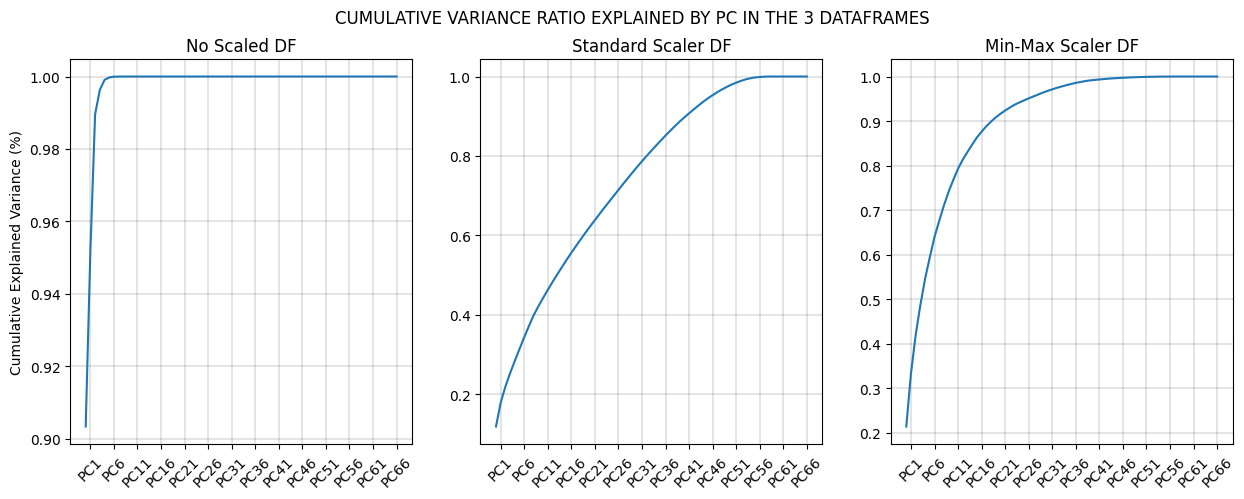

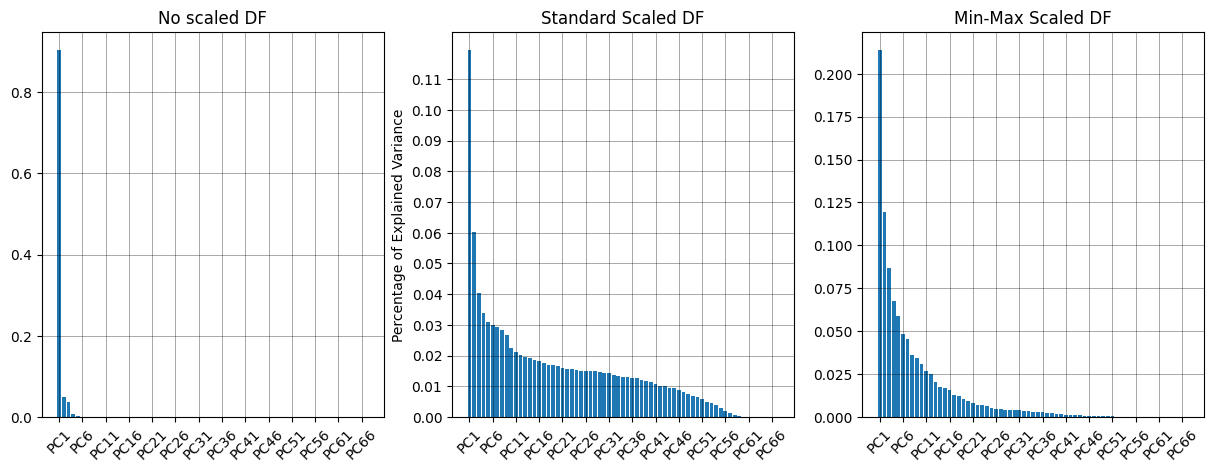

In [18]:
#INITIALIZE THE PCA
pca_full_noscale = PCA()
pca_full_mm = PCA()
pca_full_std = PCA()

#FIT OUR DATAFRAMES
pca_full_noscale.fit(np.array(XworkDF))
pca_full_std.fit(np.array(Xworkdf_std))
pca_full_mm.fit(np.array(Xworkdf_mm))

#EXPLAINED VARIANCE
expl_var_noscale = pca_full_noscale.explained_variance_ratio_
expl_var_mm = pca_full_mm.explained_variance_ratio_
expl_var_std = pca_full_std.explained_variance_ratio_

#VISUALIZE THE RESULTS
#plot of the cumulative variance
fig, axs = plt.subplots(1,3)
fig.set_size_inches(15,5)
fig.suptitle('CUMULATIVE VARIANCE RATIO EXPLAINED BY PC IN THE 3 DATAFRAMES')
#No scale
axs[0].plot(expl_var_noscale.cumsum())
axs[0].set_title('No Scaled DF')
axs[0].set_ylabel('Cumulative Explained Variance (%)')
axs[0].set_xticks(ticks = np.arange(1, pca_full_noscale.n_features_in_+1, 5), labels=[f'PC{i}' for i in range(1, pca_full_noscale.n_features_in_+1, 5)],
           rotation=45)
axs[0].grid(axis = 'both', linewidth = 0.3, alpha = 0.50)
#Standard Scaler
axs[1].plot(expl_var_std.cumsum())
axs[1].set_title('Standard Scaler DF')
axs[1].set_xticks(ticks = np.arange(1, pca_full_std.n_features_in_+1, 5), labels=[f'PC{i}' for i in range(1, pca_full_std.n_features_in_+1, 5)],
           rotation=45)
axs[1].grid(axis = 'both', linewidth = 0.3, alpha = 0.50)
#Min-Max Scaler
axs[2].plot(expl_var_mm.cumsum())
axs[2].set_title('Min-Max Scaler DF')
axs[2].set_xticks(ticks = np.arange(1, pca_full_mm.n_features_in_+1, 5), labels=[f'PC{i}' for i in range(1, pca_full_mm.n_features_in_+1, 5)],
           rotation=45)
axs[2].grid(axis = 'both', linewidth = 0.3, alpha = 0.50)
plt.show()

#bar plot representing the variance explained by each PC
#No scale
fig, axs = plt.subplots(1,3)
fig.set_size_inches(15,5)
axs[0].bar(range(1, len(expl_var_noscale) + 1), expl_var_noscale, align='center')
axs[0].set_xticks(ticks = np.arange(1, pca_full_noscale.n_features_in_+1, 5), labels=[f'PC{i}' for i in range(1, pca_full_noscale.n_features_in_+1, 5)], rotation=45)
axs[0].set_title('No scaled DF')
axs[0].grid(axis = 'both', linewidth = 0.4, alpha = 0.6)
#Standard Scaler
axs[1].set_title('Standard Scaled DF')
axs[1].set_ylabel('Percentage of Explained Variance')
axs[1].bar(range(1, len(expl_var_std) + 1), expl_var_std, align='center')
axs[1].set_xticks(ticks = np.arange(1, pca_full_std.n_features_in_+1, 5), labels=[f'PC{i}' for i in range(1, pca_full_std.n_features_in_+1, 5)], rotation=45)
axs[1].set_yticks(np.arange(0, expl_var_std[0], 0.01))
axs[1].grid(axis = 'both', linewidth = 0.4, alpha = 0.6)
#Min-Max Scaler
axs[2].bar(range(1, len(expl_var_mm) + 1), expl_var_mm, align='center')
axs[2].set_xticks(ticks = np.arange(1, pca_full_mm.n_features_in_+1, 5), labels=[f'PC{i}' for i in range(1, pca_full_mm.n_features_in_+1, 5)], rotation=45)
axs[2].set_title('Min-Max Scaled DF')
axs[2].grid(axis = 'both', linewidth = 0.4, alpha = 0.6)
plt.show()

The curve of the cumulative variance, combined with the bar plot of the variance explained by each principal component give more information about the performances of the PCA on the different scaled dataframes.
It is shown that the **Original dataframe** is almost all explicable by the first 3 principal components, while the remaining components give barely no contribution. This can indicate that few features dominate the variability, leading to biased results in downstream analyses.
The plots of the **Standard Scaled Dataframe** showcase how eliminating scale differences between features allows the principal components to capture variance based on the relative importance of each feature. In fact, the contribution given by each principal component is more evenly distributed that the in the other two DFs,  indicating a balanced representation of the underlying variance. To cover the $90 \%$ of the latter over 41 principal components are needed.
Lastly, the **Min-Max Scaled Dataframe** preserves the original distribution and relationships of the data within a specific range, providing a fairer comparison of the underlying variability. It is a middle ground compared to the other two DFs in terms of variance explained, covering the $90 \%$ of it when reaching the $16$-th principal component.


###### TODO: check

## Exercise 4. (Dimensionality Reduction and Interpretation of the PCs
### Section (a)
Let's find the number of principal components explaining at least the 35% of the total variance. According to the suggestions, we select m features that satisfy  m = min\{m_(35\%), 5}. We notice that, in the StandardScaler DF, 5 components are not enough to cover the $35\%$ of variance, but at least $8$ are needed. In the MinMax Scaled DF, instead, we need 3 PCs to cover the $41.98\%$ of the total variance.

STD: PCs needed to cover 35% of variance: 8
MINMAX: PCs needed to cover 35% of variance: 3


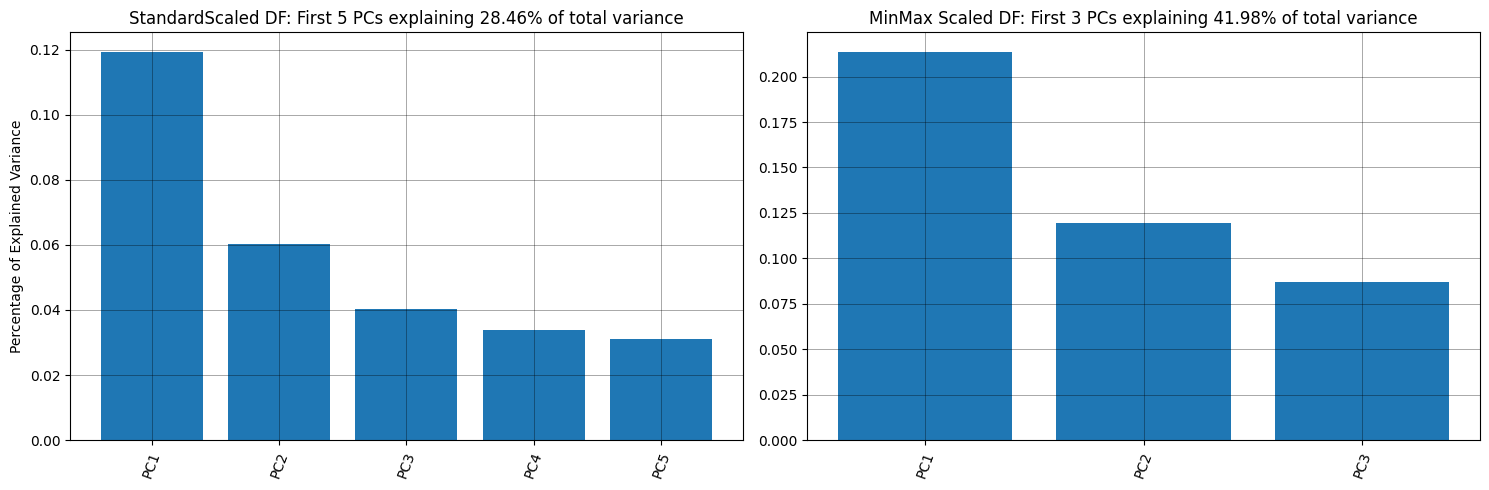

In [19]:
#CHOOSING M
m_prime_std = np.argmax(np.cumsum(expl_var_std) >= 0.35) + 1
m_prime_mm = np.argmax(np.cumsum(expl_var_mm) >= 0.35) + 1
print(f'STD: PCs needed to cover 35% of variance: {m_prime_std}')
print(f'MINMAX: PCs needed to cover 35% of variance: {m_prime_mm}')
m_std = min(m_prime_std, 5)
m_mm = min(m_prime_mm, 5)

#perform PCA using the first m choosen principal component only
# INITIALIZE THE PCA
pca_m_std = PCA(n_components=m_std)
pca_m_mm = PCA(n_components=m_mm)

# FIT THE PCA
Ystd_df = pca_m_std.fit_transform(Xworkdf_std)
Ymm_df = pca_m_mm.fit_transform(Xworkdf_mm)
#barplots of the variance explained

expl_var_std = pca_m_std.explained_variance_ratio_
expl_var_mm = pca_m_mm.explained_variance_ratio_

#STANDARD SCALER
round_expl_var_ratio = np.round(expl_var_std.sum() * 100, 2)
fig, axs = plt.subplots(1,2)
fig.set_size_inches(15,5)
axs[0].bar(range(1, m_std + 1), expl_var_std[:m_std], align='center')
axs[0].set_title(f"StandardScaled DF: First {format(m_std)} PCs explaining {round_expl_var_ratio}% of total variance")
axs[0].set_xticks(ticks= range(1, m_std + 1), labels = [f'PC{i}' for i in range(1, m_std+1)], rotation=70)
axs[0].set_ylabel('Percentage of Explained Variance')
axs[0].grid(axis = 'both', linewidth = 0.4, alpha = 0.6)

#MINMAX SCALER
round_expl_var_ratio = np.round(expl_var_mm.sum() * 100, 2)
axs[1].bar(range(1, m_mm + 1), expl_var_mm[:m_mm], align='center')
axs[1].set_title(f"MinMax Scaled DF: First {format(m_mm)} PCs explaining {round_expl_var_ratio}% of total variance")
axs[1].set_xticks(ticks= range(1, m_mm + 1), labels = [f'PC{i}' for i in range(1, m_mm+1)], rotation=70)
axs[1].grid(axis = 'both', linewidth = 0.4, alpha = 0.6)
plt.tight_layout()
plt.show()

### Section (b)
To interpret result we plot the loading graph, i.e. a bar plot showing the contribute of each feature taken into account in the PCA. Moreover, each loading graph contains two dotted lines, representing a threshold given by the expression $\epsilon = \sqrt{1/n}$ ($n$ is the number of features). For an optimal interpretation of the results, all the feature loadings (in absolute value) greater than the $ \epsilon $ should be considered as relevant.

#### **Standard scaler dataframe**

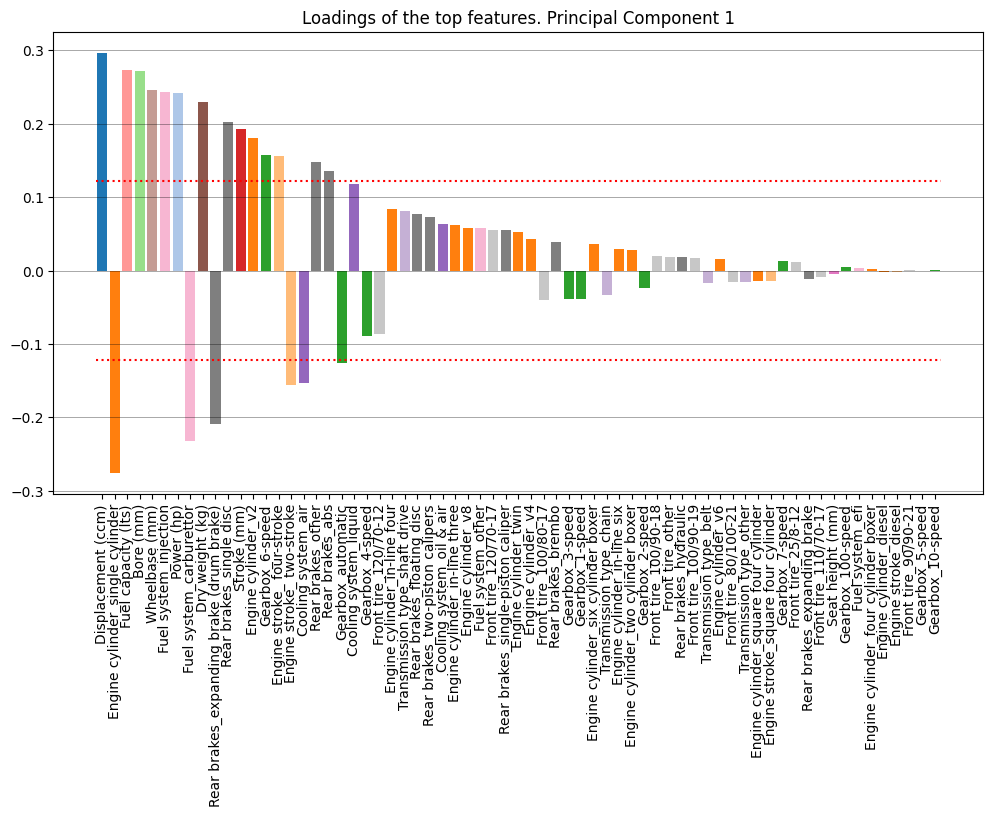

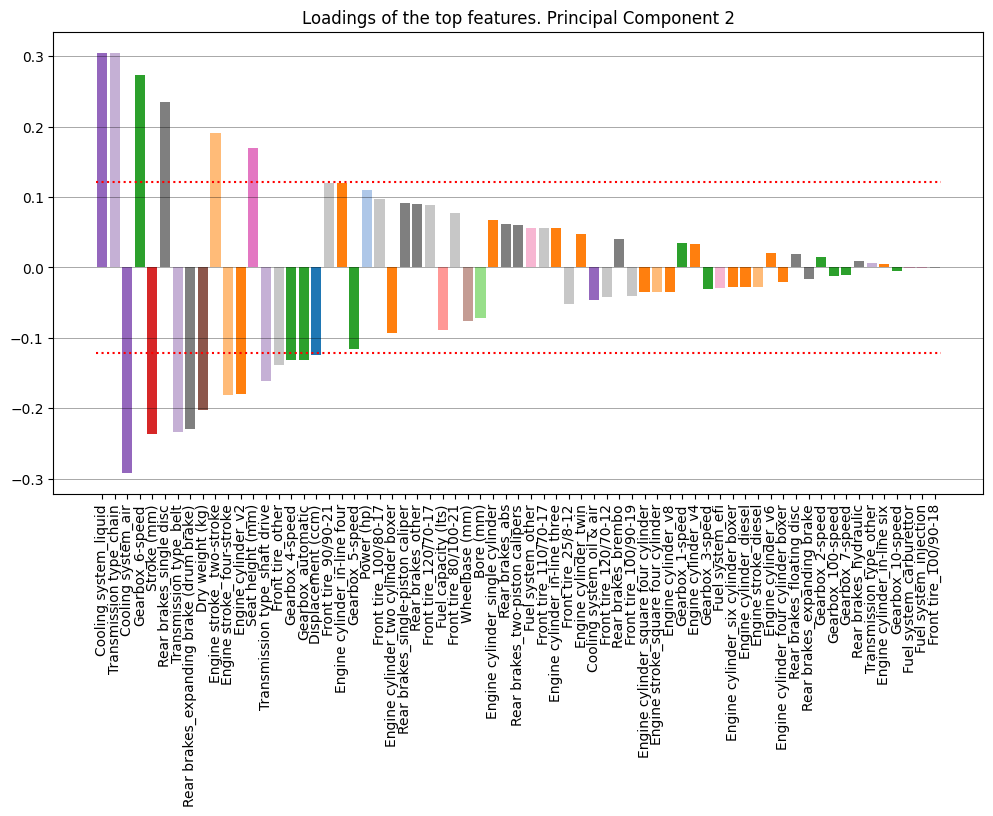

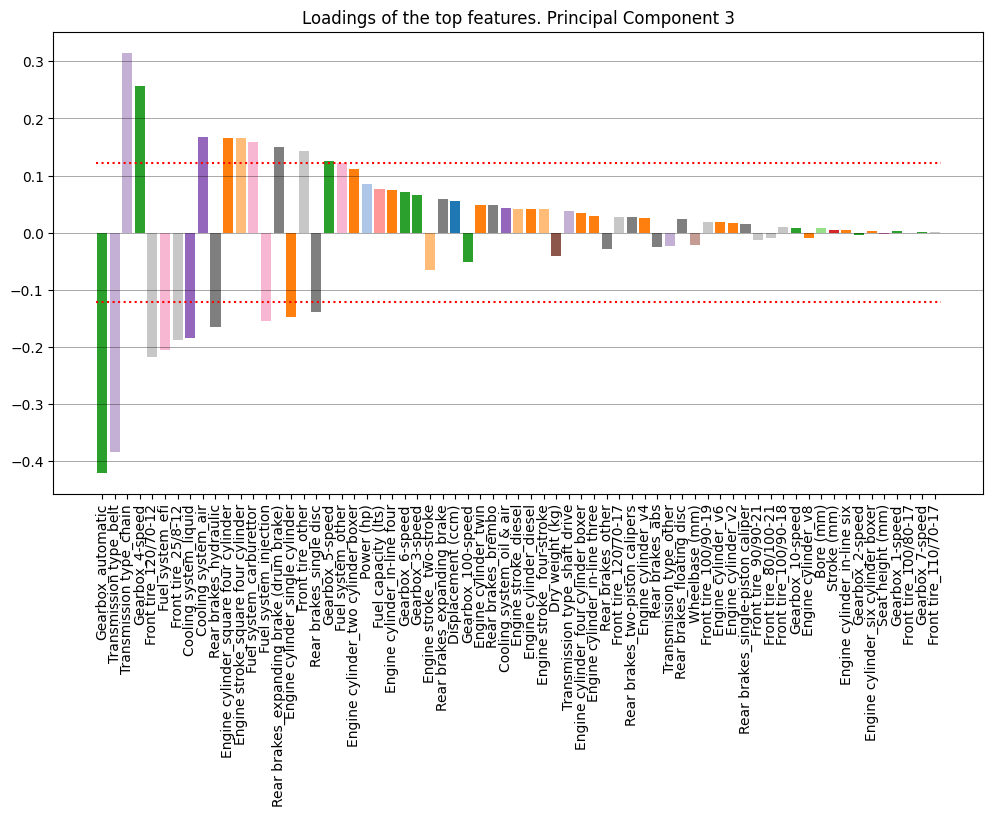

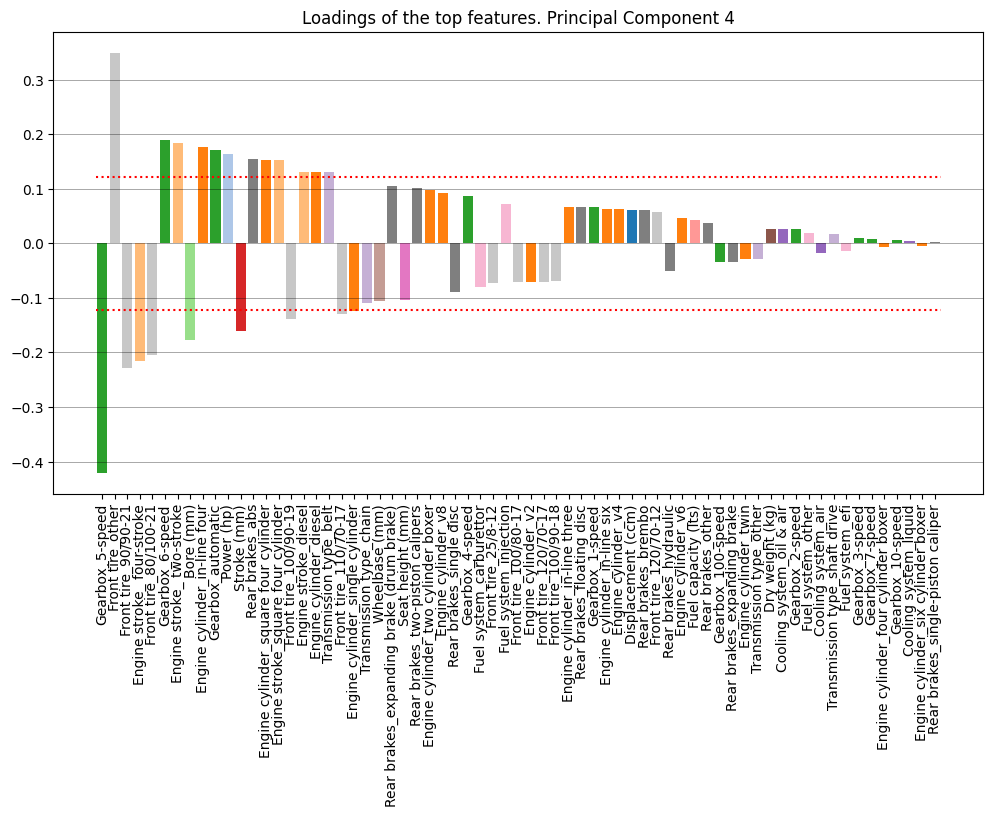

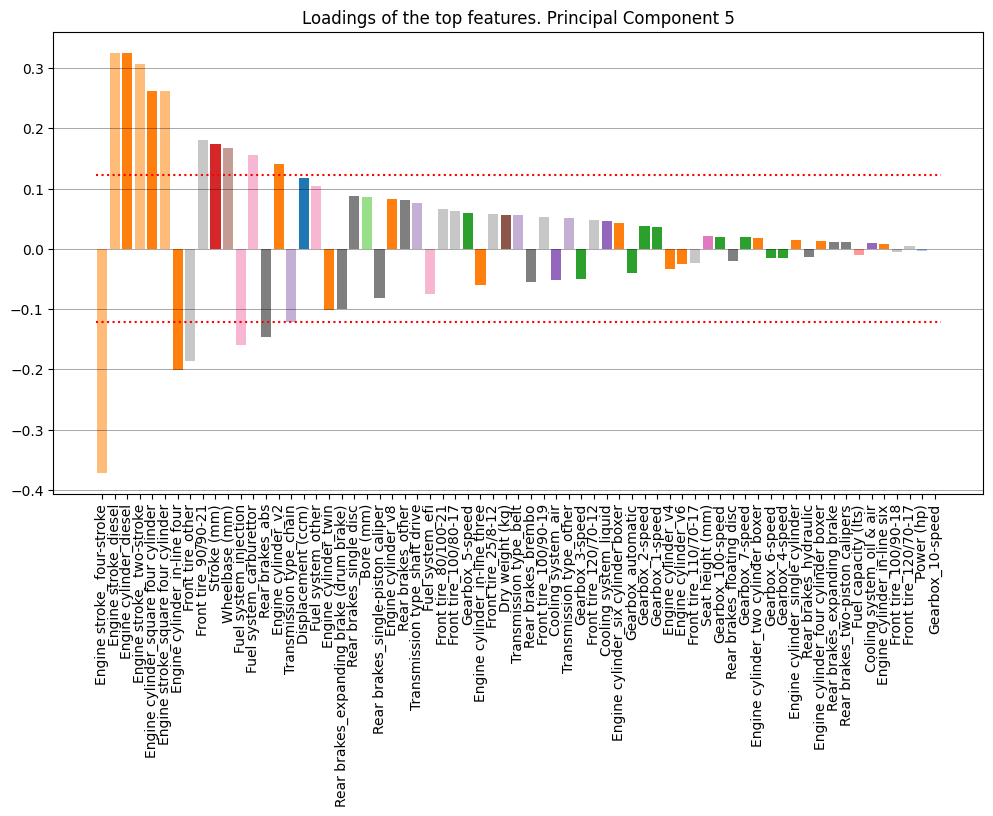

Results on StandardScaled DF for the first 5 PCs
Top 5 features for PC1: ['Displacement (ccm)', 'Engine cylinder_single cylinder', 'Fuel capacity (lts)', 'Bore (mm)', 'Wheelbase (mm)']
Top 5 features for PC2: ['Cooling system_liquid', 'Transmission type_chain', 'Cooling system_air', 'Gearbox_6-speed', 'Stroke (mm)']
Top 5 features for PC3: ['Gearbox_automatic', 'Transmission type_belt', 'Transmission type_chain', 'Gearbox_4-speed', 'Front tire_120/70-12']
Top 5 features for PC4: ['Gearbox_5-speed', 'Front tire_other', 'Front tire_90/90-21', 'Engine stroke_ four-stroke', 'Front tire_80/100-21']
Top 5 features for PC5: ['Engine stroke_ four-stroke', 'Engine stroke_diesel', 'Engine cylinder_diesel', 'Engine stroke_ two-stroke', 'Engine cylinder_square four cylinder']


In [20]:
#LOADINGS GRAPH FOR STANDARD SCALED DATAFRAME
eps1 = np.sqrt(1 / pca_m_std.n_features_in_)

#get the loadings of each feature for each pc of the m selected
loadings = pca_m_std.components_
topfeat_std = [] #this is an array of list: i stands for the i-th PC, and the cell is a ordered list of the 5 best influencing feature for that PC
for i in range(m_std):
    # Sort the loadings for the current component in descending order
    component_loadings = loadings[i]
    sorted_loadings = sorted(enumerate(component_loadings), key=lambda x: -abs(x[1]))

    #feature_indices = range(len(component_loadings))           #switch comment lines to have unordered loadings
    feature_indices = [index for index, _ in sorted_loadings]
    features = list(Xworkdf_std.columns[feature_indices])
    topfeat_std.append(features)

    #plot the barplot
    fig, ax = plt.subplots(figsize=(12,6))

    #plot the red line denoting the threshold [-eps , +eps]
    plt.plot([-0.5, pca_m_std.n_features_in_ - 0.5], [eps1, eps1], 'red', linestyle = 'dotted')
    plt.plot([-0.5, pca_m_std.n_features_in_ - 0.5], [-eps1, -eps1], 'red', linestyle = 'dotted')

    #use the general feature color to set the color of each bar
    feature_colors = [general_feature_colors[c.split('_')[0]] for c in features]
    ax.bar(features, component_loadings[feature_indices], color=feature_colors)
    ax.set_title(f'Loadings of the top features. Principal Component {i+1}')
    ax.tick_params(axis='x', rotation=90)
    ax.grid(axis='y', linewidth=0.4, alpha = 0.6)
    plt.show()


#print the top features for each component
print(f"Results on StandardScaled DF for the first {m_std} PCs")
for i in range(m_std):
    print(f"Top 5 features for PC{i+1}: {topfeat_std[i][:5]}")

#### Interpreting results:
The bar plots above give a visualization of the feature loadings in descendant order, thus the first $x$ bars are the most significant, $x$ varying according to each principal component. For simplicity, the first $5$ have been listed above. However, to interpret the meaning of each principal component, we made a singular, case-by-case reasoning.

###### TODOOOOO: CHECK
1. PC1: **Engine size and motorcycle size** being *Displacement (ccm)*, *Fuel capacity (lts)*, *Bore (mm)*,  and *Wheelbase (mm)* of positive loadings while *Single cylinder* of negative loading, indicator of a less powerful technology.
2. PC2: **Performance enhancement [+] VS Traditional Setup [-]**. The highest positive loadings for this PC are *liquid* as Cooling System, *chain* as Transmission Type, *6-speed* Gearbox and single disc brakes. The negative loading features are *air* cooling system, *belt* transmission, *stroke (mm)* and expanding brake (drum brake). It suggests that this principal component captures the trade-off between performance-enhancing elements and more traditional aspects of the system.
3. PC3: **Automatic gearbox and belt [+] VS Manual and chain [-]**. This component distinguishes between motorcycles that may have a more automated and convenient riding experience (*automatic* gearbox and *belt* transmission) versus motorcycles that require manual shifting and potentially offer higher performance capabilities (*manual* gearbox with *4-speed* and *chain* transmission).
4. PC4: **Gearbox and Tire Type Differentiation**. Based on these loadings, we can interpret this principal component as one that highlights the role of transmission (changing gear within a transmission system) and tire type in differentiating the system.
5. PC5: **Diesel technology and Square Four cylinder**. This name indicates that the fourth principal component captures the differentiation related to engine stroke and cylinder types, particularly focusing on the positive loadings for engine stroke_diesel, engine cylinder_diesel, engine stroke_square four cylinder, and engine cylinder_square four cylinder. These loadings suggest a preference or emphasis on these specific configurations in the dataset.


In [21]:
#GIVE NAMES TO THE PCA COMPONENTS ACCORDING TO LOADINGS
pc_std_names =['Engine size and motorcycle size',
                'Performance enhancement [+] VS Traditional Setup [-]',
                'Automatic gearbox and belt [+] VS Manual and chain [-]',
                'Gearbox and Tire Type Differentiation',
                'Diesel technology and Square Four cylinder']


 #### Min-Max Scaler dataframe

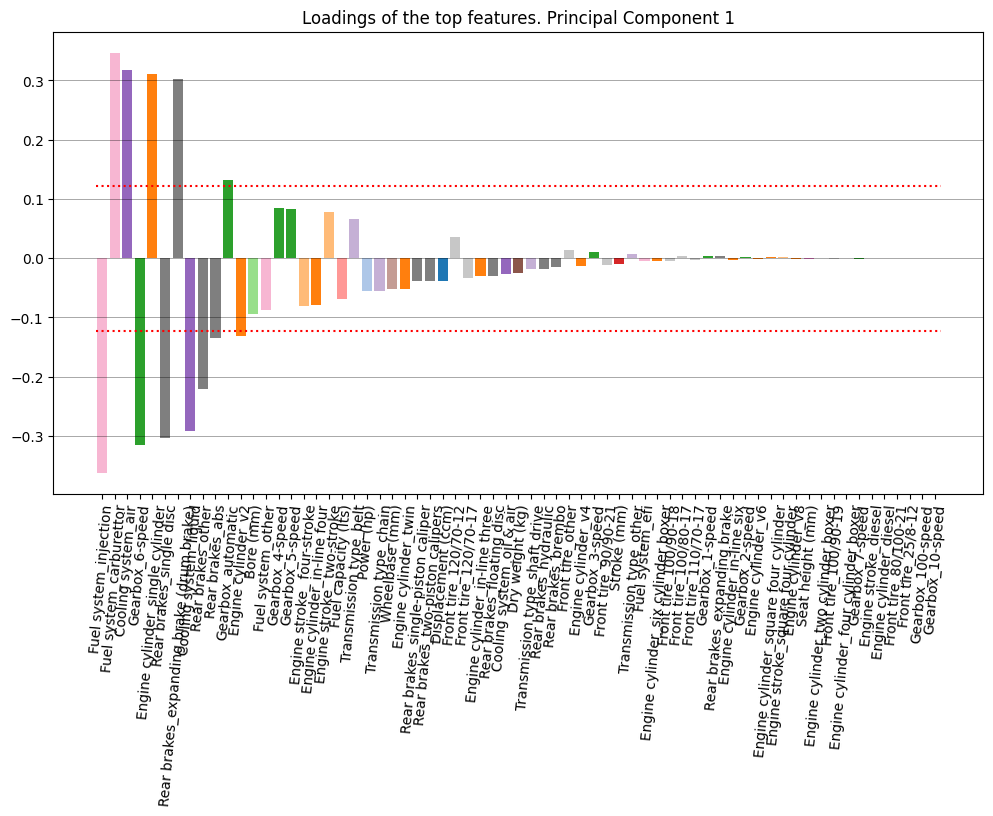

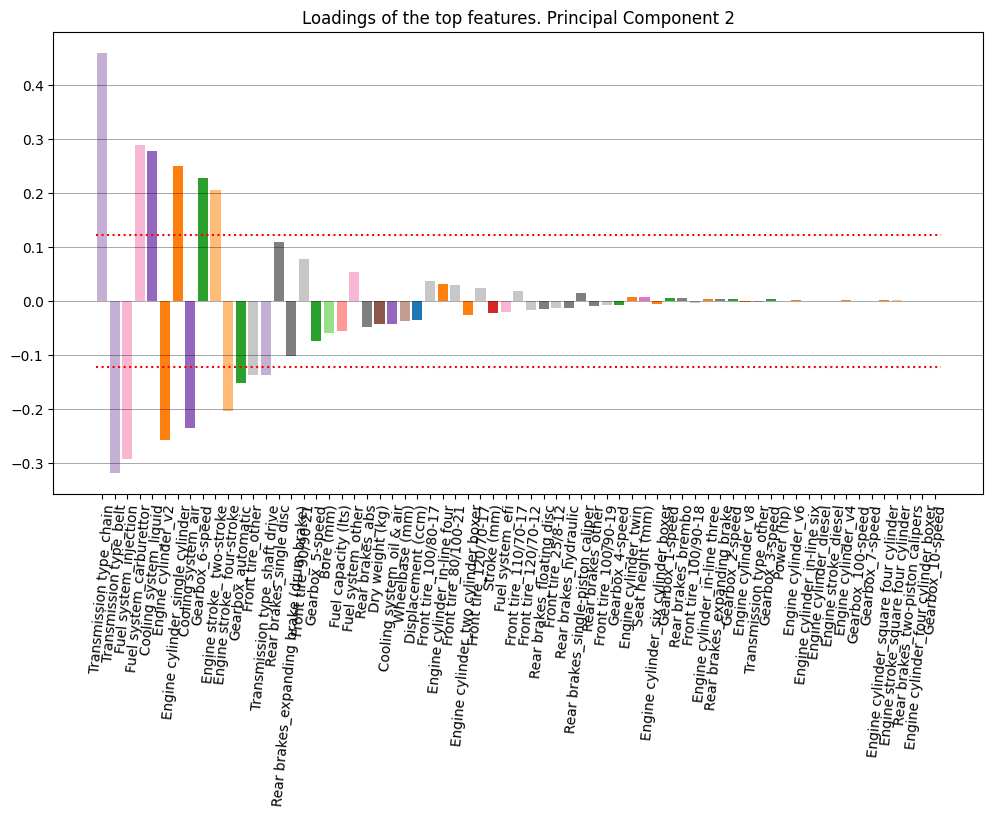

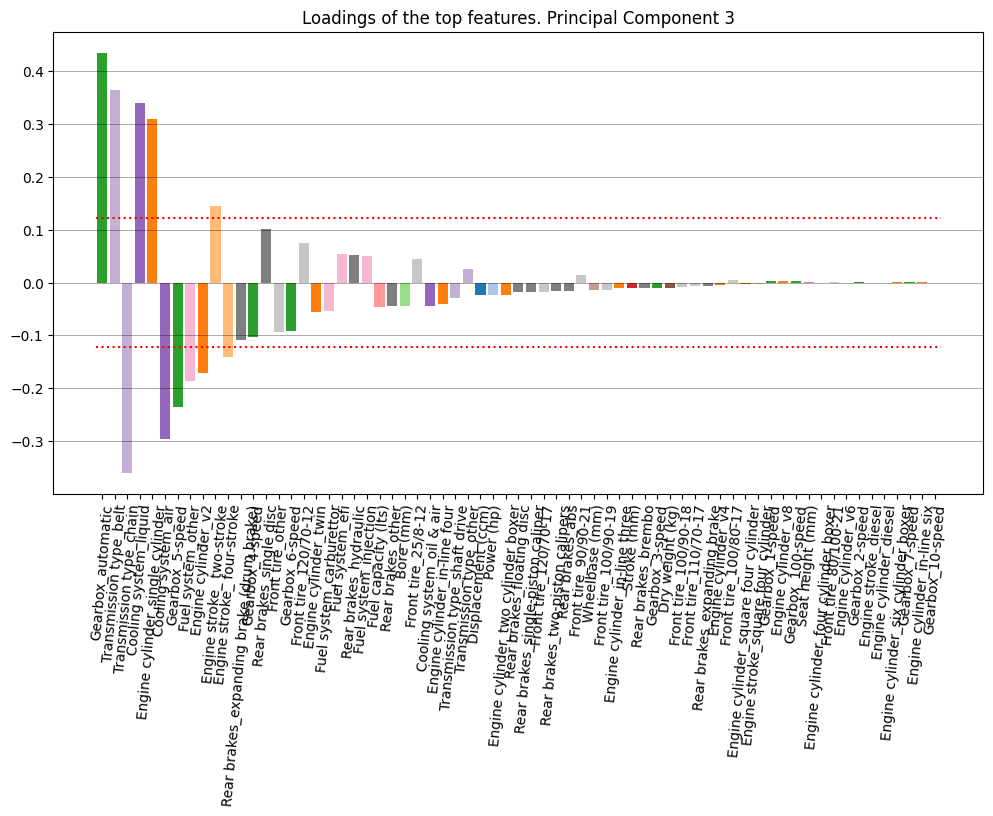


Results on MinMaxScaled DF for the first 3 PCs
Top 5 positive features features for PC1: ['Fuel system_injection', 'Fuel system_carburettor', 'Cooling system_air', 'Gearbox_6-speed', 'Engine cylinder_single cylinder']
Top 5 positive features features for PC2: ['Transmission type_chain', 'Transmission type_belt', 'Fuel system_injection', 'Fuel system_carburettor', 'Cooling system_liquid']
Top 5 positive features features for PC3: ['Gearbox_automatic', 'Transmission type_belt', 'Transmission type_chain', 'Cooling system_liquid', 'Engine cylinder_single cylinder']


In [22]:
# LOADINGS GRAPH FOR MIN-MAX SCALED DATAFRAME
eps2 = np.sqrt(1 / pca_m_mm.n_features_in_)

#get the loadings of each feature for each pc of the m selected
loadings = pca_m_mm.components_
topfeat_mm = []

for i in range(m_mm):
    # Sort the loadings for the current component in descending order
    component_loadings = loadings[i]
    sorted_loadings = sorted(enumerate(component_loadings), key=lambda x: -abs(x[1]))

    #feature_indices = range(len(component_loadings))           #switch comment lines to have unordered loadings
    feature_indices = [index for index, _ in sorted_loadings]
    features = list(Xworkdf_std.columns[feature_indices])
    topfeat_mm.append(features)

    #plot the barplot
    fig, ax = plt.subplots(figsize=(12,6))

    #plot the red line denoting the threshold [-eps , +eps]
    plt.plot([-0.5, pca_m_mm.n_features_in_ - 0.5], [eps2, eps2], 'red', linestyle = 'dotted')
    plt.plot([-0.5, pca_m_mm.n_features_in_ - 0.5], [-eps2, -eps2], 'red', linestyle = 'dotted')

    #use the general feature color to set the color of each bar
    feature_colors = [general_feature_colors[c.split('_')[0]] for c in features]
    ax.bar(features, component_loadings[feature_indices], color=feature_colors)
    ax.set_title(f'Loadings of the top features. Principal Component {i+1}')
    ax.tick_params(axis='x', rotation=85)
    ax.grid(axis='y', linewidth=0.4, alpha = 0.6)
    plt.show()

#print the top features for each component
print(f"\nResults on MinMaxScaled DF for the first {m_mm} PCs")

#print the top features for each component
for i in range(m_mm):
    print(f"Top 5 positive features features for PC{i+1}: {topfeat_mm[i][:5]}")


#### Interpreting results:
1. PC1: **Fuel System and Engine Type**. We can interpret this principal component as capturing a contrast between motorcycles with different fuel systems, engine types, and cooling systems. It suggests a distinction between motorcycles with carburetors, air cooling systems and single-cylinder engines versus motorcycles with fuel injection, liquid cooling systems, and potentially more modern or advanced technologies.
2. PC2: **Chain and carburettor [+] VS Belt and injection [-]** OPPURE **Transmission and Fuel System Preference**. This name reflects the influence of variables related to transmission type (belt [+] vs. chain [-]) and fuel system (carburettor [+] vs. injection [-]) on the motorcycles represented in this principal component. It also indicates a preference for motorcycles with chain transmissions and carburettor fuel system over those with belt and injection, implying that the choice of chain transmission and carburetor fuel system may be associated with certain performance advantages or operational characteristics, while the alternative options (belt and injection) may offer different benefits or trade-offs.
3. PC3: **Automatic, liquid, belt [+] vs manual, air and chain [-]**. The principal component captures the diversity or variation related to transmission type (including automatic gearbox and belt transmission) and cooling system (including liquid cooling system) in the dataset. It acknowledges the significance of gearbox differences alongside the cooling system variations, highlighting the different combinations and their impact on the observed patterns in the data.


In [65]:
#GIVING NAMES TO THE PCA COMPONENTS ACCORDING TO LOADINGS
pc_mm_names =['Fuel System and Engine Type',
              'Chain and carburettor [+] VS Belt and injection [-]',
              'Automatic, liquid, belt [+] vs manual, air and chain [-]']


### Section (c)
This section is used to represent the score graph with respect to the first $3$ PCs for the Standard Scaled Dataframe and the first $2$ PCs for the Min-Max Scaled Dataframe. The score graph is realized using the scatter function of *matplotlib* library.

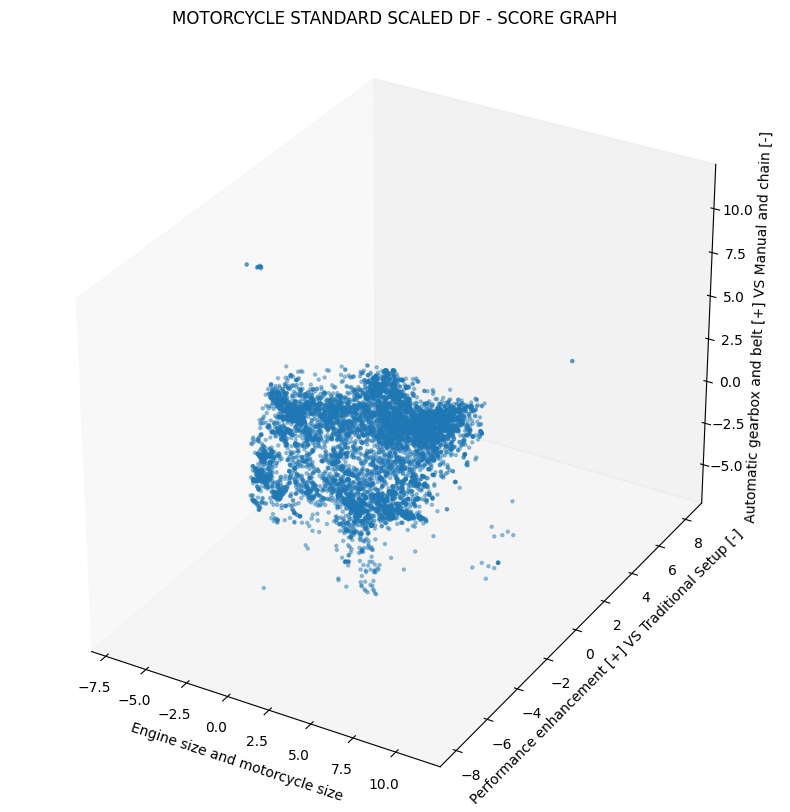

In [24]:
#SCORE GRAPH OF THE FIRST 3 PCS. STANDARD SCALED DF
fig_3d = plt.figure(figsize=(8,10))
ax_3d = fig_3d.add_subplot(111, projection='3d')
ax_3d.scatter(Ystd_df[:, 0], Ystd_df[:, 1], Ystd_df[:, 2], s=5, alpha = 0.4)
ax_3d.set_box_aspect((1, 1.4, 1))
plt.title('MOTORCYCLE STANDARD SCALED DF - SCORE GRAPH')
ax_3d.set_xlabel(pc_std_names[0])
ax_3d.set_ylabel(pc_std_names[1])
ax_3d.set_zlabel(pc_std_names[2])

ax_3d.set_zlim(min(Ystd_df[:, 2]), max(Ystd_df[:, 2]))
plt.subplots_adjust(left= 0.2)
#ax_3d.view_init(elev=20, azim=50)
ax_3d.grid(False)
fig_3d.tight_layout()
plt.show()




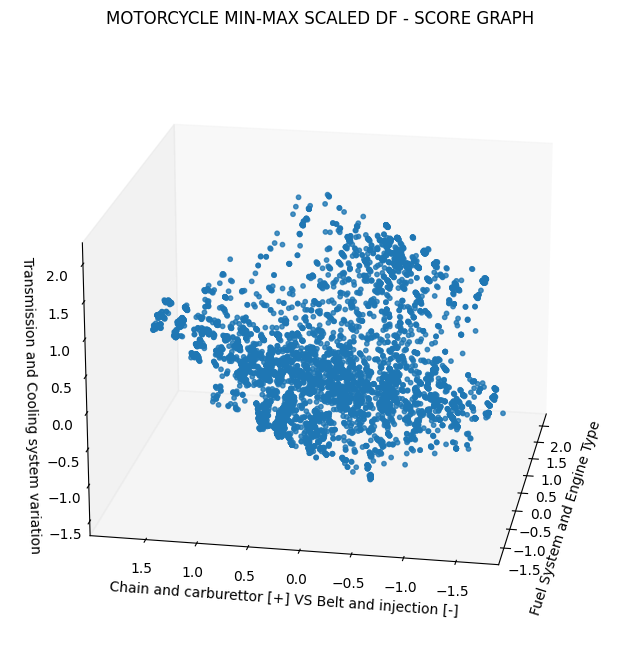

In [25]:
#SCORE GRAPH OF THE FIRST 2 PCS. MIN-MAX SCALED DF
fig_3d = plt.figure(figsize=(8, 10))
ax = fig_3d.add_subplot(111, projection='3d')
ax.scatter(Ymm_df[:, 0], Ymm_df[:, 1], Ymm_df[:,2], s=10, alpha = 0.8)
ax_3d.set_box_aspect((1, 1, 1))
plt.title('MOTORCYCLE MIN-MAX SCALED DF - SCORE GRAPH')
ax.set_xlabel(pc_mm_names[0])
ax.set_ylabel(pc_mm_names[1])
ax.set_zlabel(pc_mm_names[2])
ax.view_init(elev=20, azim=-170)
ax.grid(False)

plt.show()


### Section (d). Optional
The following code snippet aims to plot score graphs with respect to brands and categories, labels contained in the first 5 columns of our original dataframe. To do so, we proceed coloring the values for each chosen label, and then we plot the dots according to their label value.

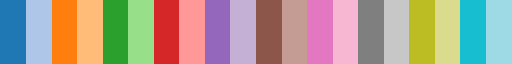

CATEGORIES:Category
Scooter                      1244
Sport                        1117
Enduro / offroad             1010
Custom / cruiser              939
Naked bike                    818
Allround                      534
Super motard                  455
ATV                           410
Touring                       339
Classic                       309
Cross / motocross             295
Sport touring                 227
Trial                         132
Minibike, cross               101
Minibike, sport                29
Prototype / concept model      15
Name: count, dtype: int64

BRANDS: There are 258 brands of motorcycles in the dataframe.


In [26]:
#COLORING CATEGORIES
colors1 = cm.tab20.colors
display(cm.tab20)
categories = LabelsDF['Category'].unique()
categories_colors = {categories[i]: colors1[i] for i in range(len(categories))}

# add the color columns to the Labels DF
LabelsDF['Category Color'] = [categories_colors[i] for i in LabelsDF['Category'].values]

category_counts = LabelsDF['Category'].value_counts()
print(f'CATEGORIES:{category_counts}')

# make a custom legend for colors
categories_colors_legend = [Line2D([0], [0], color=categories_colors[k]) for k in categories_colors.keys()]

#COLORING BRANDS
brands = LabelsDF['Brand'].unique()
print(f'\nBRANDS: There are {len(brands)} brands of motorcycles in the dataframe.')
#print(list(brands))
#colors2 = cm.tab20_r.colors
#display(cm.tab20_r)
#dictionary assigning a color to each category
#brands_colors = {brands[i]: colors2[i] for i in range(len(brands))}
#LabelsDF['Brand Color'] = [brands_colors[i] for i in LabelsDF['Brand']]



#### Score graphs with respect to category. Standard scaled DF

1. **3D Score Graph of Standard Scaled DataFrame with respect to the label: *Category***.  The following plot shows the dots (motorcyles) colored according to the category they are classified in. The interpretation is not the easiest, as the dataframe lists 16 categories. However, a few groupings stand out:
**Scooters** in light blue, **Sport** in light green with sparse dots in dark green representing **Enduro/offroad** in between, **ATV** in dark orange, and **Custom/cruiser** in dark red, group that also contains the most of the outliers.


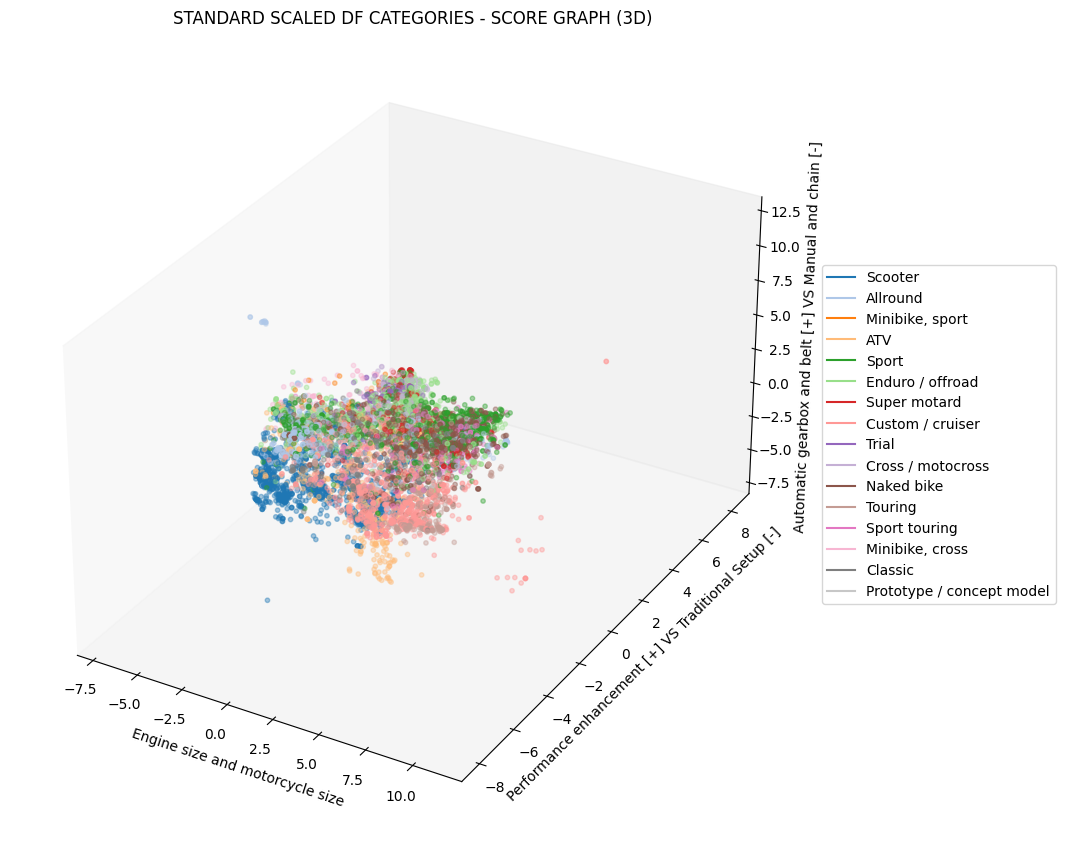

In [27]:
#STANDARD SCALED DATAFRAME - 3D SCORE GRAPH COLORED BY CATEGORY
fig_3d = plt.figure(figsize=(14,14))
ax_3d = fig_3d.add_subplot(111, projection='3d')
ax_3d.scatter(Ystd_df[:, 0], Ystd_df[:, 1], Ystd_df[:, 2], s=10,  c = LabelsDF['Category Color'].values, alpha = 0.4)
ax_3d.set_box_aspect((1, 1.4, 0.8))
plt.title('STANDARD SCALED DF CATEGORIES - SCORE GRAPH (3D)')
ax_3d.set_xlabel(pc_std_names[0])
ax_3d.set_ylabel(pc_std_names[1])
ax_3d.set_zlabel(pc_std_names[2])

legend = plt.legend(categories_colors_legend, [k for k in categories_colors.keys()], loc='center left', bbox_to_anchor=(1, 0.5))
# Move the legend outside the graph
legend.get_frame().set_facecolor('white')
plt.subplots_adjust(right=0.7)
#ax_3d.view_init(elev=10, azim=-140)
#ax_3d.view_init(elev=20, azim=-160)
ax_3d.grid(False)

plt.show()


2. **2D Score Graph of Standard Scaled DataFrame with respect to the label: *Category***. Here we consider only the first two principal components: the one that identifies the engine and motorbike dimensions and the one that summarises the features discerning scooters and small bikes from sport and adventure ones.


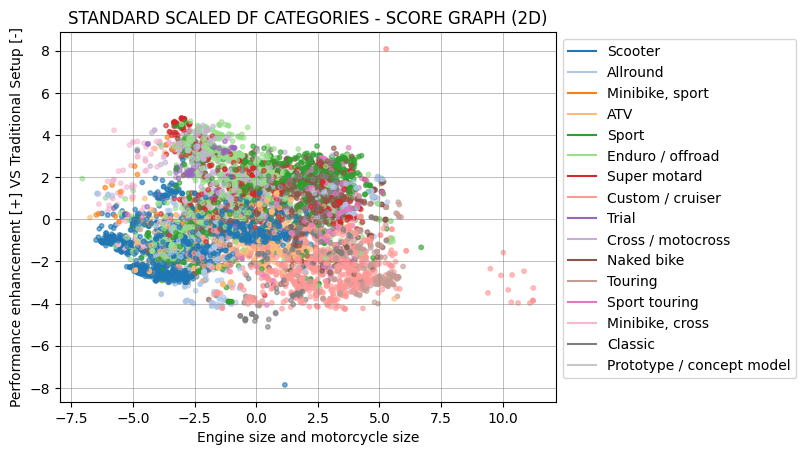

In [28]:
plt.figure()
plt.scatter(Ystd_df[:, 0], Ystd_df[:, 1], s=10, c=LabelsDF['Category Color'].values, alpha=0.6)
plt.title('STANDARD SCALED DF CATEGORIES - SCORE GRAPH (2D)')
plt.xlabel(pc_std_names[0])
plt.ylabel(pc_std_names[1])
legend = plt.legend(categories_colors_legend, [k for k in categories_colors.keys()], loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True, color = 'gray', linewidth = 0.6, alpha = 0.6)
plt.show()

3. The **2D Score Graph of Standard Scaled DataFrame with respect to the label: *Category*** shows motorcycles space distribution according to the engine and motorbike dimensions (1st PC on the x-axis) and to the transmission type and gearbox system (3rd PC on the y-axis).


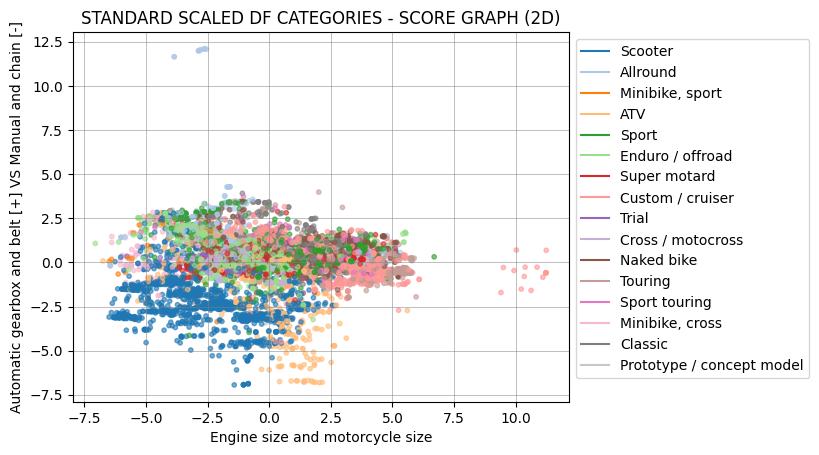

In [29]:
plt.figure()
plt.scatter(Ystd_df[:, 0], Ystd_df[:, 2], s=10, c=LabelsDF['Category Color'].values, alpha=0.6)
plt.title('STANDARD SCALED DF CATEGORIES - SCORE GRAPH (2D)')
plt.xlabel(pc_std_names[0])
plt.ylabel(pc_std_names[2])
legend = plt.legend(categories_colors_legend, [k for k in categories_colors.keys()], loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True, color = 'gray', linewidth = 0.6, alpha = 0.6)
plt.show()

4. Here we plot the **3D Score Graph of Standard Scaled DataFrame with respect to only few *Categories***. We have selected only 5 of these and filtered data according to their belonging to one of these. Indeed, we have observed that these categories are dominant in our dataframe. The score graph below shows the correspondant clusters.

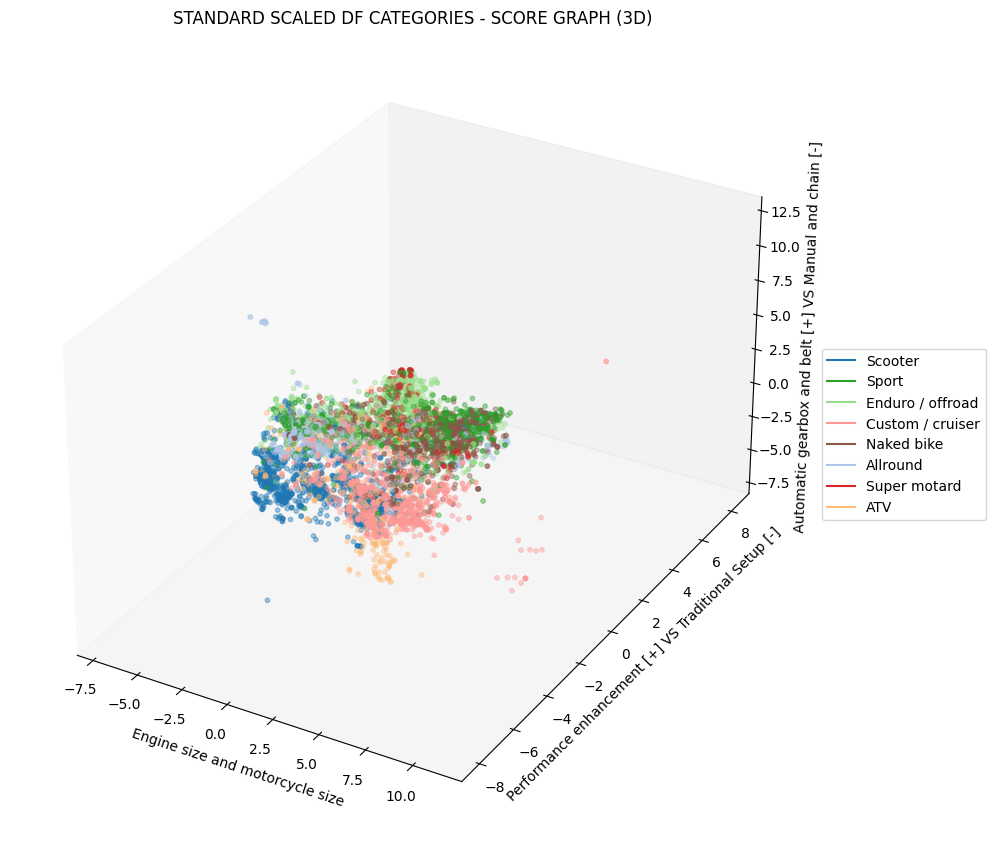

In [30]:
fig_3d = plt.figure(figsize=(14, 14))
ax_3d = fig_3d.add_subplot(111, projection='3d')

# Select the desired categories to plot
selected_categories = ['Scooter', 'Sport', 'Enduro / offroad', 'Custom / cruiser', 'Naked bike', 'Allround', 'Super motard', 'ATV']

# Filter the data based on the selected categories
filtered_Ydf = Ystd_df[LabelsDF['Category'].isin(selected_categories)]
filtered_colors = LabelsDF[LabelsDF['Category'].isin(selected_categories)]

# Extract a new dictionary for selected categories
selected_colors = {category: categories_colors[category] for category in selected_categories}

# Plot the filtered data points
ax_3d.scatter(filtered_Ydf[:, 0], filtered_Ydf[:, 1], filtered_Ydf[:, 2], s=10, c=filtered_colors['Category Color'].values, alpha=0.4)
ax_3d.set_box_aspect((1, 1.4, 0.8))
plt.title('STANDARD SCALED DF CATEGORIES - SCORE GRAPH (3D)')
ax_3d.set_xlabel(pc_std_names[0])
ax_3d.set_ylabel(pc_std_names[1])
ax_3d.set_zlabel(pc_std_names[2])

# Add legend of the filtered categories
legend_elements = [Line2D([0], [0], color=selected_colors[category], label=category) for category in selected_categories]
legend = plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))

#legend = plt.legend(categories_colors_legend, [k for k in selected_colors.keys()], loc='center left', bbox_to_anchor=(1, 0.5))
legend.get_frame().set_facecolor('white')
plt.subplots_adjust(right=0.7)
#ax_3d.view_init(elev=10, azim=-140)
#ax_3d.view_init(azim=-160)
ax_3d.grid(False)

plt.show()


5. Lastly, we plot two **2D score graphs with respect to *Year* and *Rating***. Dots are colored based on these labels following a continuous colormap.

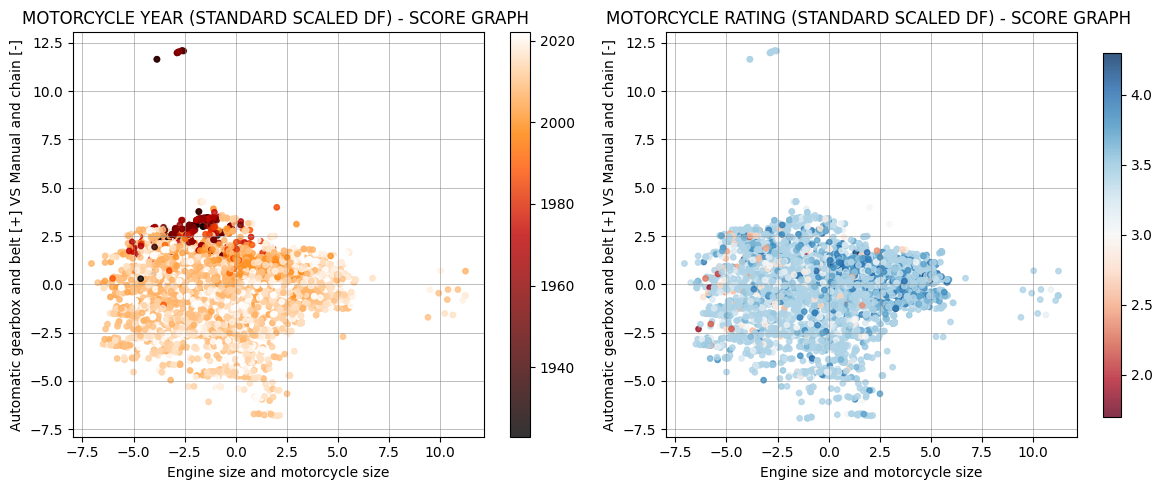

In [31]:
#2D SCORE GRAPH COLORED BY THE YEAR LABEL AND RATING LABEL
fig, axes = plt.subplots(1,2)
fig.set_size_inches(12,5)
year_scatter = axes[0].scatter(Ystd_df[:, 0], Ystd_df[:, 2], s=15, c=LabelsDF['Year'].values, cmap='gist_heat', alpha=0.8)
axes[0].set_title('MOTORCYCLE YEAR (STANDARD SCALED DF) - SCORE GRAPH ')
axes[0].set_xlabel(pc_std_names[0])
axes[0].set_ylabel(pc_std_names[2])
plt.colorbar(year_scatter)
axes[0].grid(True, color = 'gray', linewidth = 0.6, alpha = 0.6)

rating_scatter = axes[1].scatter(Ystd_df[:, 0], Ystd_df[:, 2], s=15,  c = LabelsDF['Rating'].values, cmap='RdBu', alpha=0.8)
axes[1].set_title('MOTORCYCLE RATING (STANDARD SCALED DF) - SCORE GRAPH ')
axes[1].set_xlabel(pc_std_names[0])
axes[1].set_ylabel(pc_std_names[2])
plt.colorbar(rating_scatter, shrink=0.9)
axes[1].grid(True, color = 'gray', linewidth = 0.6, alpha = 0.6)
plt.tight_layout()
plt.show()

1. **2D Score Graph of Min-Max Scaled DataFrame with respect to the label: *Category***. The following plot shows dots colored by categories for the dataframe scaled with the Min-max scaler. The full list of categories is shown. Differently from the standard scaled dataframe, groupings are not so evident, even if the dominance of few categories is clear.


#### Score graphs with respect to category. Standard scaled DF
1. **3D Score Graph of Standard Scaled DataFrame with respect to the label: *Category***.
2.
3. ###### TODO: check and change
The following plot shows the dots (motorcycles) colored according to the category they are classified in. The interpretation is not the easiest, as the dataframe lists 16 categories. However, a few groupings stand out:
**Scooters** in light blue, **Sport** in light green with sparse dots in dark green representing **Enduro/offroad** in between, **ATV** in dark orange, and **Custom/cruiser** in dark red, group that also contains the most of the outliers.

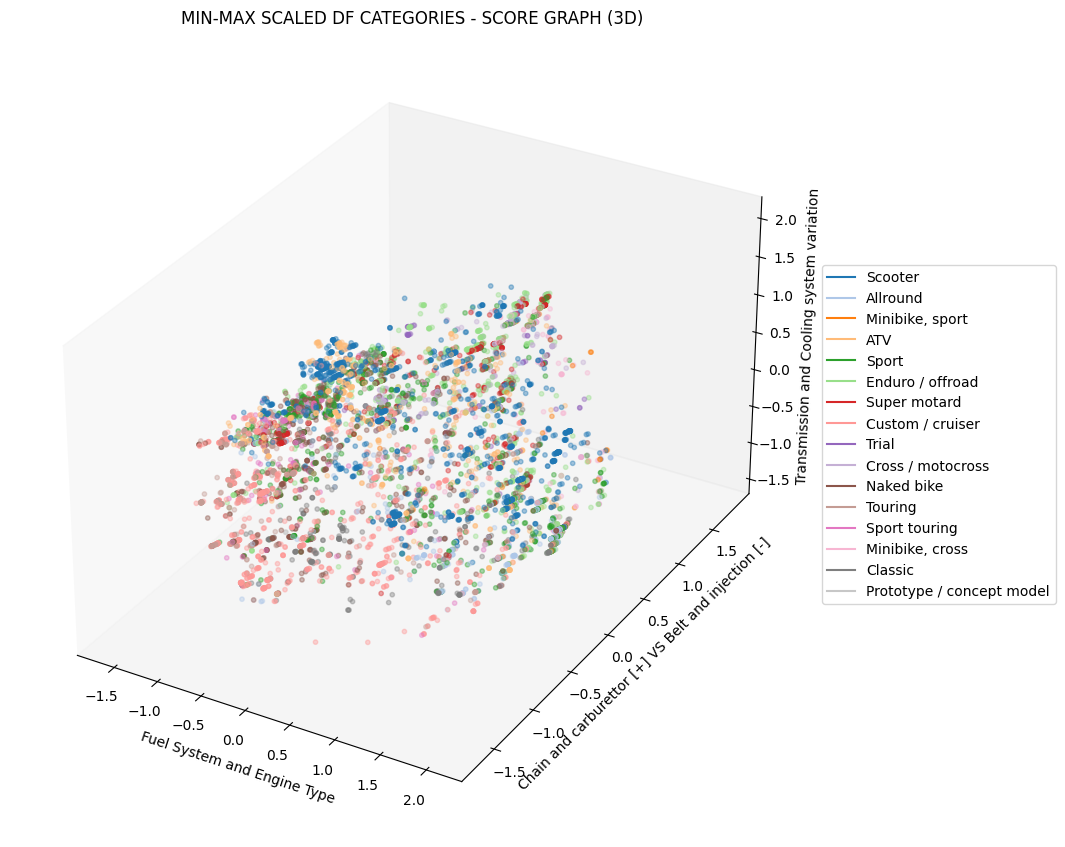

In [32]:
#MIN-MAX SCALED DATAFRAME - 3D SCORE GRAPH COLORED BY CATEGORY
fig_3d = plt.figure(figsize=(14,14))
ax_3d = fig_3d.add_subplot(111, projection='3d')
ax_3d.scatter(Ymm_df[:, 0], Ymm_df[:, 1], Ymm_df[:, 2], s=10,  c = LabelsDF['Category Color'].values, alpha = 0.4)
ax_3d.set_box_aspect((1, 1.4, 0.8))
plt.title('MIN-MAX SCALED DF CATEGORIES - SCORE GRAPH (3D)')
ax_3d.set_xlabel(pc_mm_names[0])
ax_3d.set_ylabel(pc_mm_names[1])
ax_3d.set_zlabel(pc_mm_names[2])

legend = plt.legend(categories_colors_legend, [k for k in categories_colors.keys()], loc='center left', bbox_to_anchor=(1, 0.5))
# Move the legend outside the graph
legend.get_frame().set_facecolor('white')
plt.subplots_adjust(right=0.7)
#ax_3d.view_init(elev=10, azim=-140)
#ax_3d.view_init(elev=20, azim=-160)
ax_3d.grid(False)

plt.show()

2. **2D Score Graph of Min-Max Scaled DataFrame with respect to the label: *Category***. Here we consider only the first two principal components: the one that identifies the engine and motorbike dimensions and the one that summarises the features discerning scooters and small bikes from sport and adventure ones.


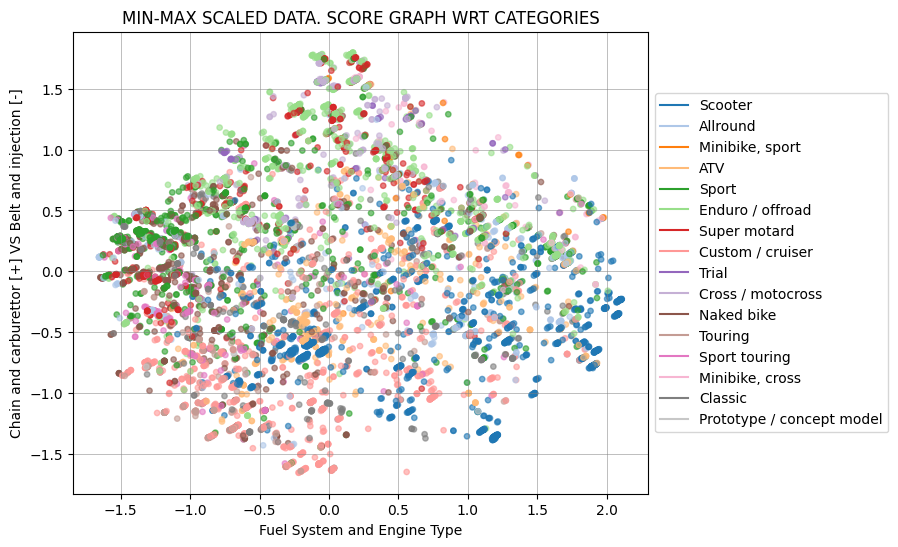

In [33]:
# MIN-MAX SCALED DATAFRAME - 2D SCORE GRAPH COLORED BY CATEGORY
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(Ymm_df[:, 0], Ymm_df[:, 1], s=15,  c = LabelsDF['Category Color'].values, alpha=0.6)
plt.title('MIN-MAX SCALED DATA. SCORE GRAPH WRT CATEGORIES')
ax.set_xlabel(pc_mm_names[0])
ax.set_ylabel(pc_mm_names[1])

legend = plt.legend(categories_colors_legend, [k for k in categories_colors.keys()], loc='center left', bbox_to_anchor=(1, 0.5))

# Move the legend outside the graph
legend.get_frame().set_facecolor('white')
plt.subplots_adjust(right=0.7)
#ax_3d.view_init(elev=20, azim=-160)
ax.grid(True, color = 'gray', linewidth = 0.6, alpha = 0.6)

plt.show()

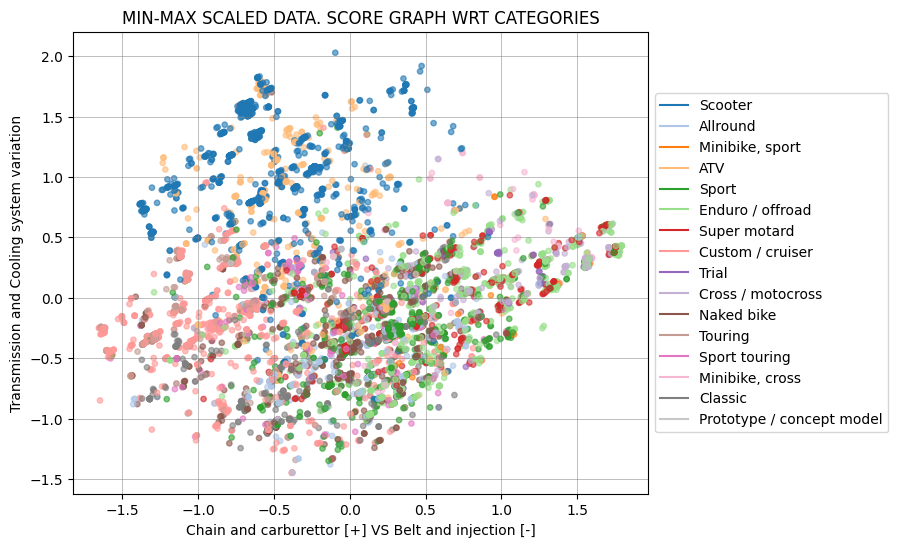

In [34]:
# MIN-MAX SCALED DATAFRAME - 2D SCORE GRAPH COLORED BY CATEGORY
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(Ymm_df[:, 1], Ymm_df[:, 2], s=15,  c = LabelsDF['Category Color'].values, alpha=0.6)
plt.title('MIN-MAX SCALED DATA. SCORE GRAPH WRT CATEGORIES')
ax.set_xlabel(pc_mm_names[1])
ax.set_ylabel(pc_mm_names[2])

legend = plt.legend(categories_colors_legend, [k for k in categories_colors.keys()], loc='center left', bbox_to_anchor=(1, 0.5))

# Move the legend outside the graph
legend.get_frame().set_facecolor('white')
plt.subplots_adjust(right=0.7)
#ax_3d.view_init(elev=20, azim=-160)
ax.grid(True, color = 'gray', linewidth = 0.6, alpha = 0.6)

plt.show()

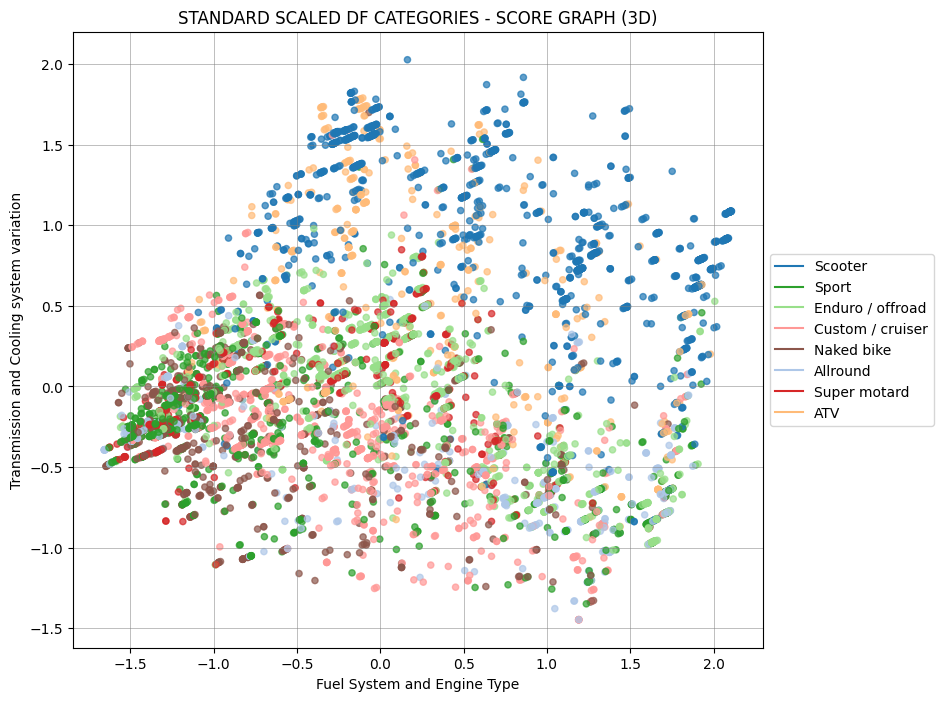

In [35]:
fig= plt.figure(figsize=(12, 8))

# Select the desired categories to plot
selected_categories = ['Scooter', 'Sport', 'Enduro / offroad', 'Custom / cruiser', 'Naked bike', 'Allround', 'Super motard', 'ATV']

# Filter the data based on the selected categories
filtered_Ymm_df = Ymm_df[LabelsDF['Category'].isin(selected_categories)]
filtered_colors = LabelsDF[LabelsDF['Category'].isin(selected_categories)]

# Extract a new dictionary for selected categories
selected_colors = {category: categories_colors[category] for category in selected_categories}

# Plot the filtered data points
plt.scatter(filtered_Ymm_df[:, 0], filtered_Ymm_df[:, 2], s=20, c=filtered_colors['Category Color'].values, alpha=0.7)
plt.title('STANDARD SCALED DF CATEGORIES - SCORE GRAPH (3D)')
plt.xlabel(pc_mm_names[0])
plt.ylabel(pc_mm_names[2])

# Add legend of the filtered categories
legend_elements = [Line2D([0], [0], color=selected_colors[category], label=category) for category in selected_categories]
legend = plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
legend.get_frame().set_facecolor('white')
plt.subplots_adjust(right=0.7)
plt.grid(True, color = 'gray', linewidth = 0.6, alpha = 0.6)
plt.show()


3. **2D Score Graph of Min-max DF with respect to *Year* and *Rating***. These plots show that the majority of our bikes was realized between $2000$ and $2020$, being the shades of purple the prevailing colour in the graph on the left. As far as the rating is concerned, we can notice that the most of the observation received a Rating of $\approx 3.5$.

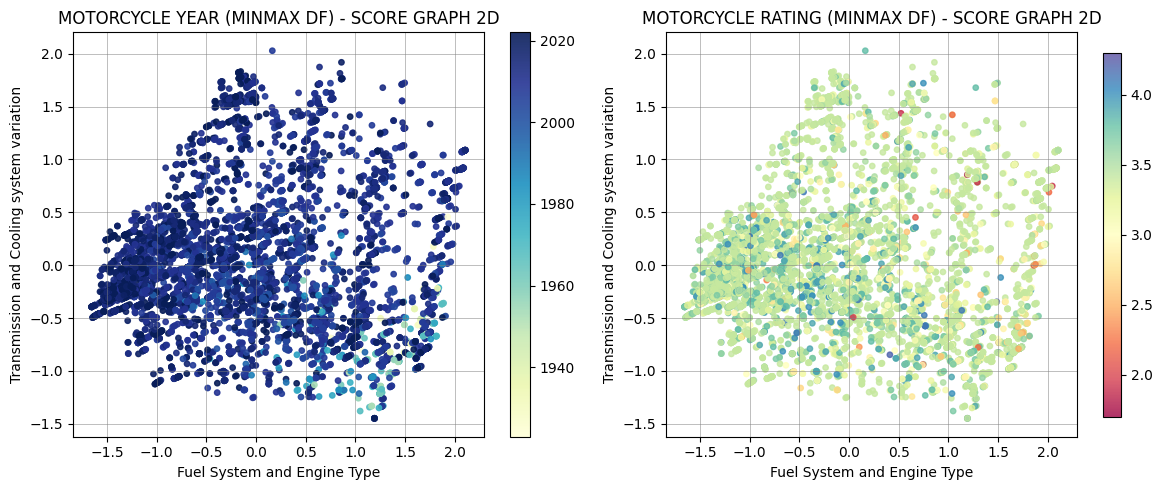

In [36]:
# 2D SCORE GRAPH
fig2, axes = plt.subplots(1,2)
fig2.set_size_inches(12,5)
year_scatter = axes[0].scatter(Ymm_df[:, 0], Ymm_df[:, 2], s=15,  c = LabelsDF['Year'].values, cmap='YlGnBu', alpha=0.9)
axes[0].set_title('MOTORCYCLE YEAR (MINMAX DF) - SCORE GRAPH 2D')
axes[0].set_xlabel(pc_mm_names[0])
axes[0].set_ylabel(pc_mm_names[2])
axes[0].grid(True, color = 'gray', linewidth = 0.6, alpha = 0.6)
plt.colorbar(year_scatter)

rating_scatter = axes[1].scatter(Ymm_df[:, 0], Ymm_df[:, 2], s=15,  c = LabelsDF['Rating'].values, cmap='Spectral', alpha=0.8)
axes[1].set_title('MOTORCYCLE RATING (MINMAX DF) - SCORE GRAPH 2D')
axes[1].set_xlabel(pc_mm_names[0])
axes[1].set_ylabel(pc_mm_names[2])
axes[1].grid(True, color = 'gray', linewidth = 0.6, alpha = 0.6)
plt.colorbar(rating_scatter, shrink=0.9)
plt.tight_layout()
plt.show()

### Exercise 5 (k-Means)
Here we run the k-Means algorthm, iterating from $k=3$ to $k = 10$. For each iteration, the *silhouette coefficient* is computed. At the end of the for loop, the highest silhouette score give the best number of clusters $k$.

In [37]:
# STANDARD SCALED DATAFRAME
# PERFORMING K MEANS WITH K IN [3,..10]
km_list = []
silcoeff_list_std = []
k_list = list(range(3, 11))

# START THE FOR-CYCLE TO RUN THE k-MEANS AND MEASURING THE SILHOUETTE COEFFICIENT
print(f'KMEANS ALGORTHM ON STANDARD-SCALED DATAFRAME')
for i in range(len(k_list)):
    print(f'Computing with k={k_list[i]}...')
    km_list.append(KMeans(n_clusters=k_list[i], n_init=3, random_state=rs))
    km = km_list[i]
    km.fit(Ystd_df)
    silcoeff_list_std.append(silhouette_score(Ystd_df, km.labels_))
    print(f'***************')
    print('')

# FIND THE BEST VALUE OF k AND THE BEST KMeans OBJECT
i_best_std = np.argmax(silcoeff_list_std)
k_std = k_list[i_best_std]
km_std = km_list[i_best_std]

# VISUALIZE THE RESULT
print('\nRESULTS OF THE SEARCH')
print(f'Best silhouette score for StandardScaled DF: {np.max(silcoeff_list_std)} with k = {k_std}')


KMEANS ALGORTHM ON STANDARD-SCALED DATAFRAME
Computing with k=3...
***************

Computing with k=4...
***************

Computing with k=5...
***************

Computing with k=6...
***************

Computing with k=7...
***************

Computing with k=8...
***************

Computing with k=9...
***************

Computing with k=10...
***************


RESULTS OF THE SEARCH
Best silhouette score for StandardScaled DF: 0.3676880021248117 with k = 8


In [38]:
print('Silhouette coefficients: \n')
for i in range(len(k_list)):
    print(f'k = {k_list[i]}: {silcoeff_list_std[i]}\n')

Silhouette coefficients: 

k = 3: 0.27595541204842483

k = 4: 0.2915555383436283

k = 5: 0.3357225307402274

k = 6: 0.34445624484074744

k = 7: 0.3497238150552558

k = 8: 0.3676880021248117

k = 9: 0.35062488361009214

k = 10: 0.32128432971858834



In [39]:
# MIN-MAX SCALED DATAFRAME
# PERFORMING K MEANS WITH K IN [3,..10]
km_list = []
silcoeff_list_mm = []
k_list = list(range(3, 11))

# START THE FOR-CYCLE TO RUN THE k-MEANS AND MEASURING THE SILHOUETTE COEFFICIENT
print(f'KMEANS ALGORTHM ON MIN-MAX-SCALED DATAFRAME')
for i in range(len(k_list)):
    print(f'k={k_list[i]}\n')
    print('Computing...')
    km_list.append(KMeans(n_clusters=k_list[i], n_init=3, random_state=rs))
    km = km_list[i]
    km.fit(Ymm_df)
    silcoeff_list_mm.append(silhouette_score(Ymm_df, km.labels_))
    print(f'***************\n')

# FIND THE BEST VALUE OF k AND THE BEST KMeans OBJECT
i_best_mm = np.argmax(silcoeff_list_mm)
k_mm = k_list[i_best_mm]
km_mm = km_list[i_best_mm]

# VISUALIZE THE RESULT
print('\nRESULTS OF THE SEARCH')
print(f'Best silhouette score for StandardScaled DF: {np.max(silcoeff_list_mm)} with k = {k_mm}')

KMEANS ALGORTHM ON MIN-MAX-SCALED DATAFRAME
k=3

Computing...
***************

k=4

Computing...
***************

k=5

Computing...
***************

k=6

Computing...
***************

k=7

Computing...
***************

k=8

Computing...
***************

k=9

Computing...
***************

k=10

Computing...
***************


RESULTS OF THE SEARCH
Best silhouette score for StandardScaled DF: 0.4514595140942864 with k = 6


In [40]:
print('Silhouette coefficients: \n')
for i in range(len(k_list)):
    print(f'k = {k_list[i]}: {silcoeff_list_mm[i]}\n')

Silhouette coefficients: 

k = 3: 0.344241038169859

k = 4: 0.4071601343512745

k = 5: 0.4244046690853225

k = 6: 0.4514595140942864

k = 7: 0.4264284642451253

k = 8: 0.4294978178596286

k = 9: 0.40847601611768214

k = 10: 0.4086523930178758



Optional: exercise 5. Playing with the parameters of the function KMeans. (max_iter and algorithm type)

In [41]:
###THESE ARE THE DEFAULT PARAMETERS OF KMEANS####
#ONLY ALGORITHM IS DIFFERENT: DEFAULT IS LLOYD
#KMeans(n_clusters=8, init="k-means++", n_init="warn", max_iter=300, tol=1e-4, verbose=(), random_state=None, copy_x=True, algorithm="elkan")
#KMeans()

In [42]:
# #Playing with other parameters for k-means. at first let's modify the number of iterations to see when the algorithm converges
# #STANDARD SCALED DATAFRAME
# km_list = []
# silcoeff_list_mm = []
# k_list = list(range(3, 11))
#
# print(f'KMEANS ALGORITHM ON MIN-MAX-SCALED DATAFRAME')
#
# for n_iter in range(1, 51):
#     print(f'n_iter={n_iter}')
#     km_list.append([])
#     silcoeff_list_mm.append([])
#     for i in range(len(k_list)):
#         print(f'k={k_list[i]}')
#         print('Computing...')
#         km_list[n_iter-1].append(KMeans(n_clusters=k_list[i], n_init=3, max_iter=n_iter, random_state=rs))
#         km = km_list[n_iter-1][i]
#         km.fit(Ymm_df)
#         silcoeff_list_mm[n_iter-1].append(silhouette_score(Ymm_df, km.labels_))
#         # print(f'n_iter={n_iter}, k={k_list[i]}, n_iter_={km.n_iter_}, sil_score={silcoeff_list_mm[n_iter-1][-1]}')
#         # print('***************')
#
# # FIND THE BEST VALUE OF k AND THE BEST KMeans OBJECT
# i_best_mm, j_best_mm = np.unravel_index(np.argmax(silcoeff_list_mm), np.shape(silcoeff_list_mm))
# k_mm = k_list[i_best_mm]
# n_iter_mm = j_best_mm + 1
# km_mm = km_list[n_iter_mm-1][i_best_mm]
#
# # VISUALIZE THE RESULT
# print('\nRESULTS OF THE SEARCH')
# print(f'Best silhouette score for Min-Max Scaled DF: {np.max(silcoeff_list_mm)} with k={k_mm}, n_iter={n_iter_mm}, and n_iter_={km_mm.n_iter_}')
#


In [43]:
# ### STD SCALED DATASET.
# #let's see how many iterations are needed to converge.
#
# # define the range of k and n_iter values to test
# k_list = list(range(3, 11))
# n_iter_list = list(range(1, 51))
#
# # create empty arrays to store the silhouette scores and best k values
# silhouette_scores = np.zeros((len(k_list), len(n_iter_list)))
# best_k_values = np.zeros(len(n_iter_list))
#
# # loop over the n_iter values
# for j, n_iter in enumerate(n_iter_list):
#     print(f'n_iter={n_iter}')
#     sil_scores = []
#     k_values = []
#     # loop over the k values
#     for i, k in enumerate(k_list):
#         km = KMeans(n_clusters=k, n_init=3, max_iter=n_iter, random_state=0)
#         km.fit(Ymm_df)
#         sil_score = silhouette_score(Ymm_df, km.labels_)
#         sil_scores.append(sil_score)
#         k_values.append(k)
#     silhouette_scores[:, j] = sil_scores
#     i_best = np.argmax(sil_scores)
#     best_k_values[j] = k_values[i_best]
#
# # plot the best k values for each n_iter
# plt.plot(n_iter_list, best_k_values)
# plt.xlabel('Number of iterations')
# plt.ylabel('Best k value')
# plt.show()


In [44]:
# TODO: elbow method for finding the optimal number of clusters in k means
# https://www.analyticsvidhya.com/blog/2021/01/in-depth-intuition-of-k-means-clustering-algorithm-in-machine-learning/
#https://www.analyticsvidhya.com/blog/2021/01/in-depth-intuition-of-k-means-clustering-algorithm-in-machine-learning/



# TODO: silhouette score evaluation
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html



### Exercise 6. Clusters and Centroid Interpretation and Visualization
In the following section we plot the dots representing the motorcycles together with the centroids, whose best number was found by maximizing the silhouette coefficient. Both 3D view and 2D view are presented, in order to have a clearer view of the possible groupings.
#### Standard Scaled Dataframe

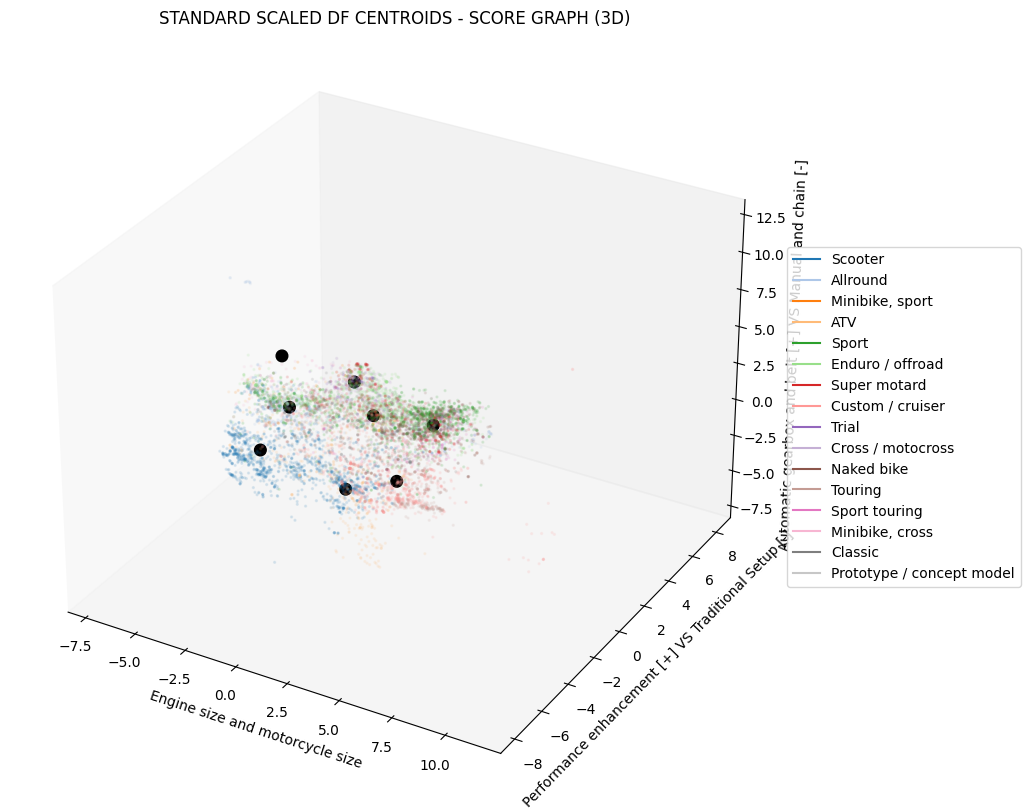

In [77]:
# MAKE THE 3D SCORE GRAPH WITH THE CENTROIDS. STD SCALED DF
# Retrieve the K-means model for k=8 (km_mm)
centroids_std=km_std.cluster_centers_

sg_std_km = plt.figure(figsize=(10, 10))
ax_sg_std_km = sg_std_km.add_subplot(111, projection='3d')
ax_sg_std_km.scatter(Ystd_df[:, 0], Ystd_df[:, 1], Ystd_df[:, 2], s=2, c=LabelsDF['Category Color'].values, alpha=0.10)
ax_sg_std_km.scatter(centroids_std[:, 0], centroids_std[:, 1], centroids_std[:, 2], s=70, c='black', alpha=1)
ax_3d.set_box_aspect((1, 1.2, 0.8))

#set writings
plt.title('STANDARD SCALED DF CENTROIDS - SCORE GRAPH (3D)')
ax_sg_std_km.set_xlabel(pc_std_names[0])
ax_sg_std_km.set_ylabel(pc_std_names[1])
ax_sg_std_km.set_zlabel(pc_std_names[2])

legend = plt.legend(categories_colors_legend, [k for k in categories_colors.keys()], loc='center left', bbox_to_anchor=(1, 0.5))
# Move the legend outside the graph
legend.get_frame().set_facecolor('white')
#plt.subplots_adjust(right=2.5)
ax_sg_std_km.grid(False)
plt.show()

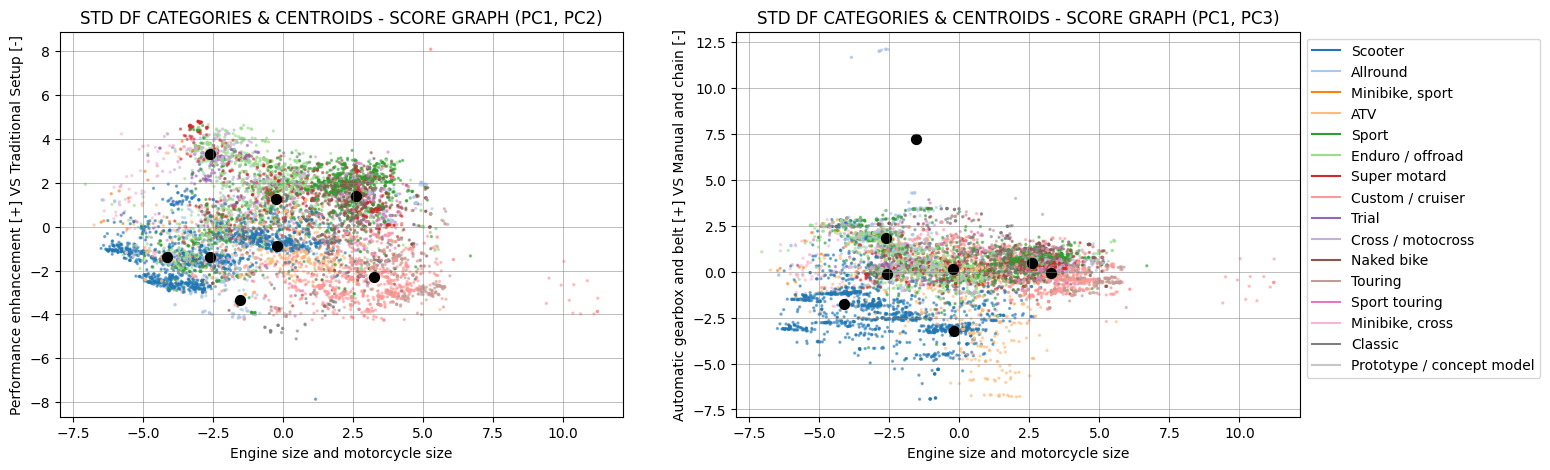

In [78]:
fig2, axes = plt.subplots(1,2)
fig2.set_size_inches(16,5)

#PRINCIPAL COMPONENTS 1 AND 2
axes[0].scatter(Ystd_df[:, 0], Ystd_df[:, 1], s=2, c=LabelsDF['Category Color'].values, alpha=0.5)
axes[0].scatter(centroids_std[:, 0], centroids_std[:, 1], s=50, c='black', alpha=1)
axes[0].set_title('STD DF CATEGORIES & CENTROIDS - SCORE GRAPH (PC1, PC2)')
axes[0].set_xlabel(pc_std_names[0])
axes[0].set_ylabel(pc_std_names[1])
axes[0].grid(True, color = 'gray', linewidth = 0.6, alpha = 0.6)

#PRINCIPAL COMPONENTS 1 AND 3
axes[1].scatter(Ystd_df[:, 0], Ystd_df[:, 2], s=2, c=LabelsDF['Category Color'].values, alpha=0.5)
axes[1].scatter(centroids_std[:, 0], centroids_std[:, 2], s=50, c='black', alpha=1)
axes[1].set_title('STD DF CATEGORIES & CENTROIDS - SCORE GRAPH (PC1, PC3)')
axes[1].set_xlabel(pc_std_names[0])
axes[1].set_ylabel(pc_std_names[2])
legend = plt.legend(categories_colors_legend, [k for k in categories_colors.keys()], loc='upper left', bbox_to_anchor=(1, 1))
axes[1].grid(True, color = 'gray', linewidth = 0.6, alpha = 0.6)

plt.show()

Due to the large number of possible categories of motorbikes, we also illustrate the graph with a reduced number of these, chosen by looking at the full graph.

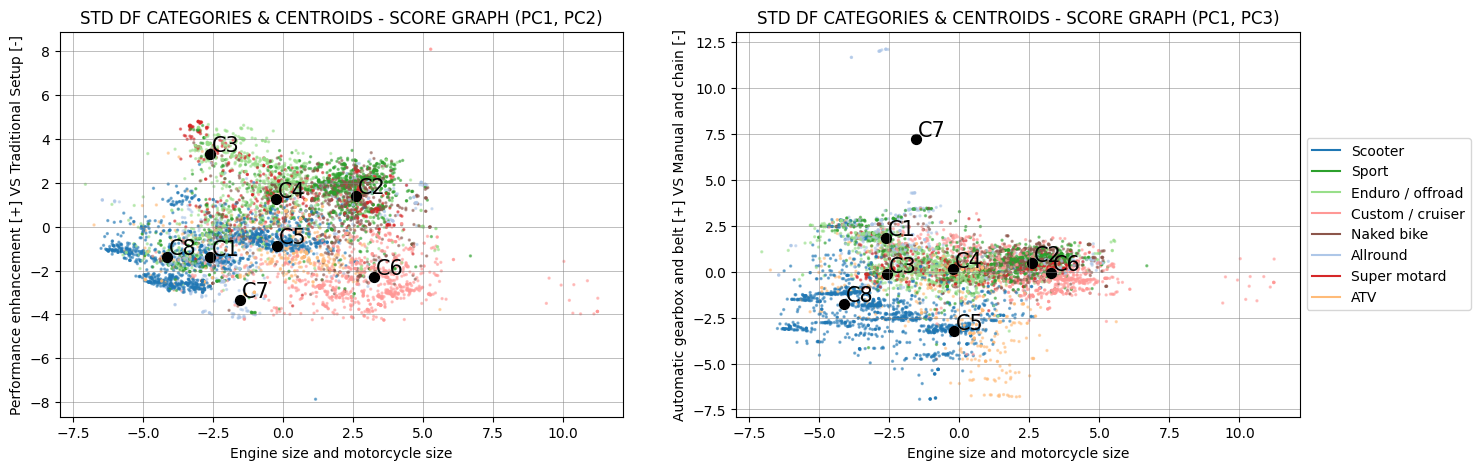

In [79]:
# Select the desired categories to plot
selected_categories = ['Scooter', 'Sport', 'Enduro / offroad', 'Custom / cruiser', 'Naked bike', 'Allround', 'Super motard', 'ATV']
#selected_categories = ['Enduro / offroad']

# Filter the data based on the selected categories
filtered_Ydf = Ystd_df[LabelsDF['Category'].isin(selected_categories)]
filtered_colors = LabelsDF[LabelsDF['Category'].isin(selected_categories)]

# Extract a new dictionary for selected categories
selected_colors = {category: categories_colors[category] for category in selected_categories}

notes = ["C1", "C2", "C3", "C4", "C5", "C6", "C7", "C8"]

fig2, axes = plt.subplots(1,2)
fig2.set_size_inches(16,5)

#PRINCIPAL COMPONENTS 1 AND 2
axes[0].scatter(filtered_Ydf[:, 0], filtered_Ydf[:, 1], s=2, c=filtered_colors['Category Color'].values, alpha=0.5)
axes[0].scatter(centroids_std[:, 0], centroids_std[:, 1], s=50, c='black', alpha=1)
axes[0].set_title('STD DF CATEGORIES & CENTROIDS - SCORE GRAPH (PC1, PC2)')
axes[0].set_xlabel(pc_std_names[0])
axes[0].set_ylabel(pc_std_names[1])
axes[0].grid(True, color = 'gray', linewidth = 0.6, alpha = 0.6)
#Add labels to centroids
for xi, yi, text in zip(centroids_std[:,0], centroids_std[:,1], notes):
    axes[0].annotate(text,
                 xy = (xi, yi), xycoords='data',
                 xytext=(1.5,1.5), textcoords='offset points',
                 color='black', fontsize=15)
#PRINCIPAL COMPONENTS 1 AND 3
axes[1].scatter(filtered_Ydf[:, 0], filtered_Ydf[:, 2], s=2, c=filtered_colors['Category Color'].values, alpha=0.5)
axes[1].scatter(centroids_std[:, 0], centroids_std[:, 2], s=50, c='black', alpha=1)
axes[1].set_title('STD DF CATEGORIES & CENTROIDS - SCORE GRAPH (PC1, PC3)')
axes[1].set_xlabel(pc_std_names[0])
axes[1].set_ylabel(pc_std_names[2])
#Add labels to centroids
for xi, yi, text in zip(centroids_std[:,0], centroids_std[:,2], notes):
    axes[1].annotate(text,
                 xy = (xi, yi), xycoords='data',
                 xytext=(1.5,1.5), textcoords='offset points',
                 color='black', fontsize=15)

# Add legend of the filtered categories
legend_elements = [Line2D([0], [0], color=selected_colors[category], label=category) for category in selected_categories]
legend = plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))

axes[1].grid(True, color = 'gray', linewidth = 0.6, alpha = 0.6)

plt.show()

**Centroid Contribution Plot, Standard Scaled DF**.
The code snippet below gives 8 barplots, one for each centroid founded for the ***Standard Scaled** dataframe. The barplots represent the contribution of each principal component for every centroid. They visually depict the relative importance or weight of each principal component, giving us the ability to determine the characteristics or attributes of each centroid in clustering analysis and, therefore, a name for it.

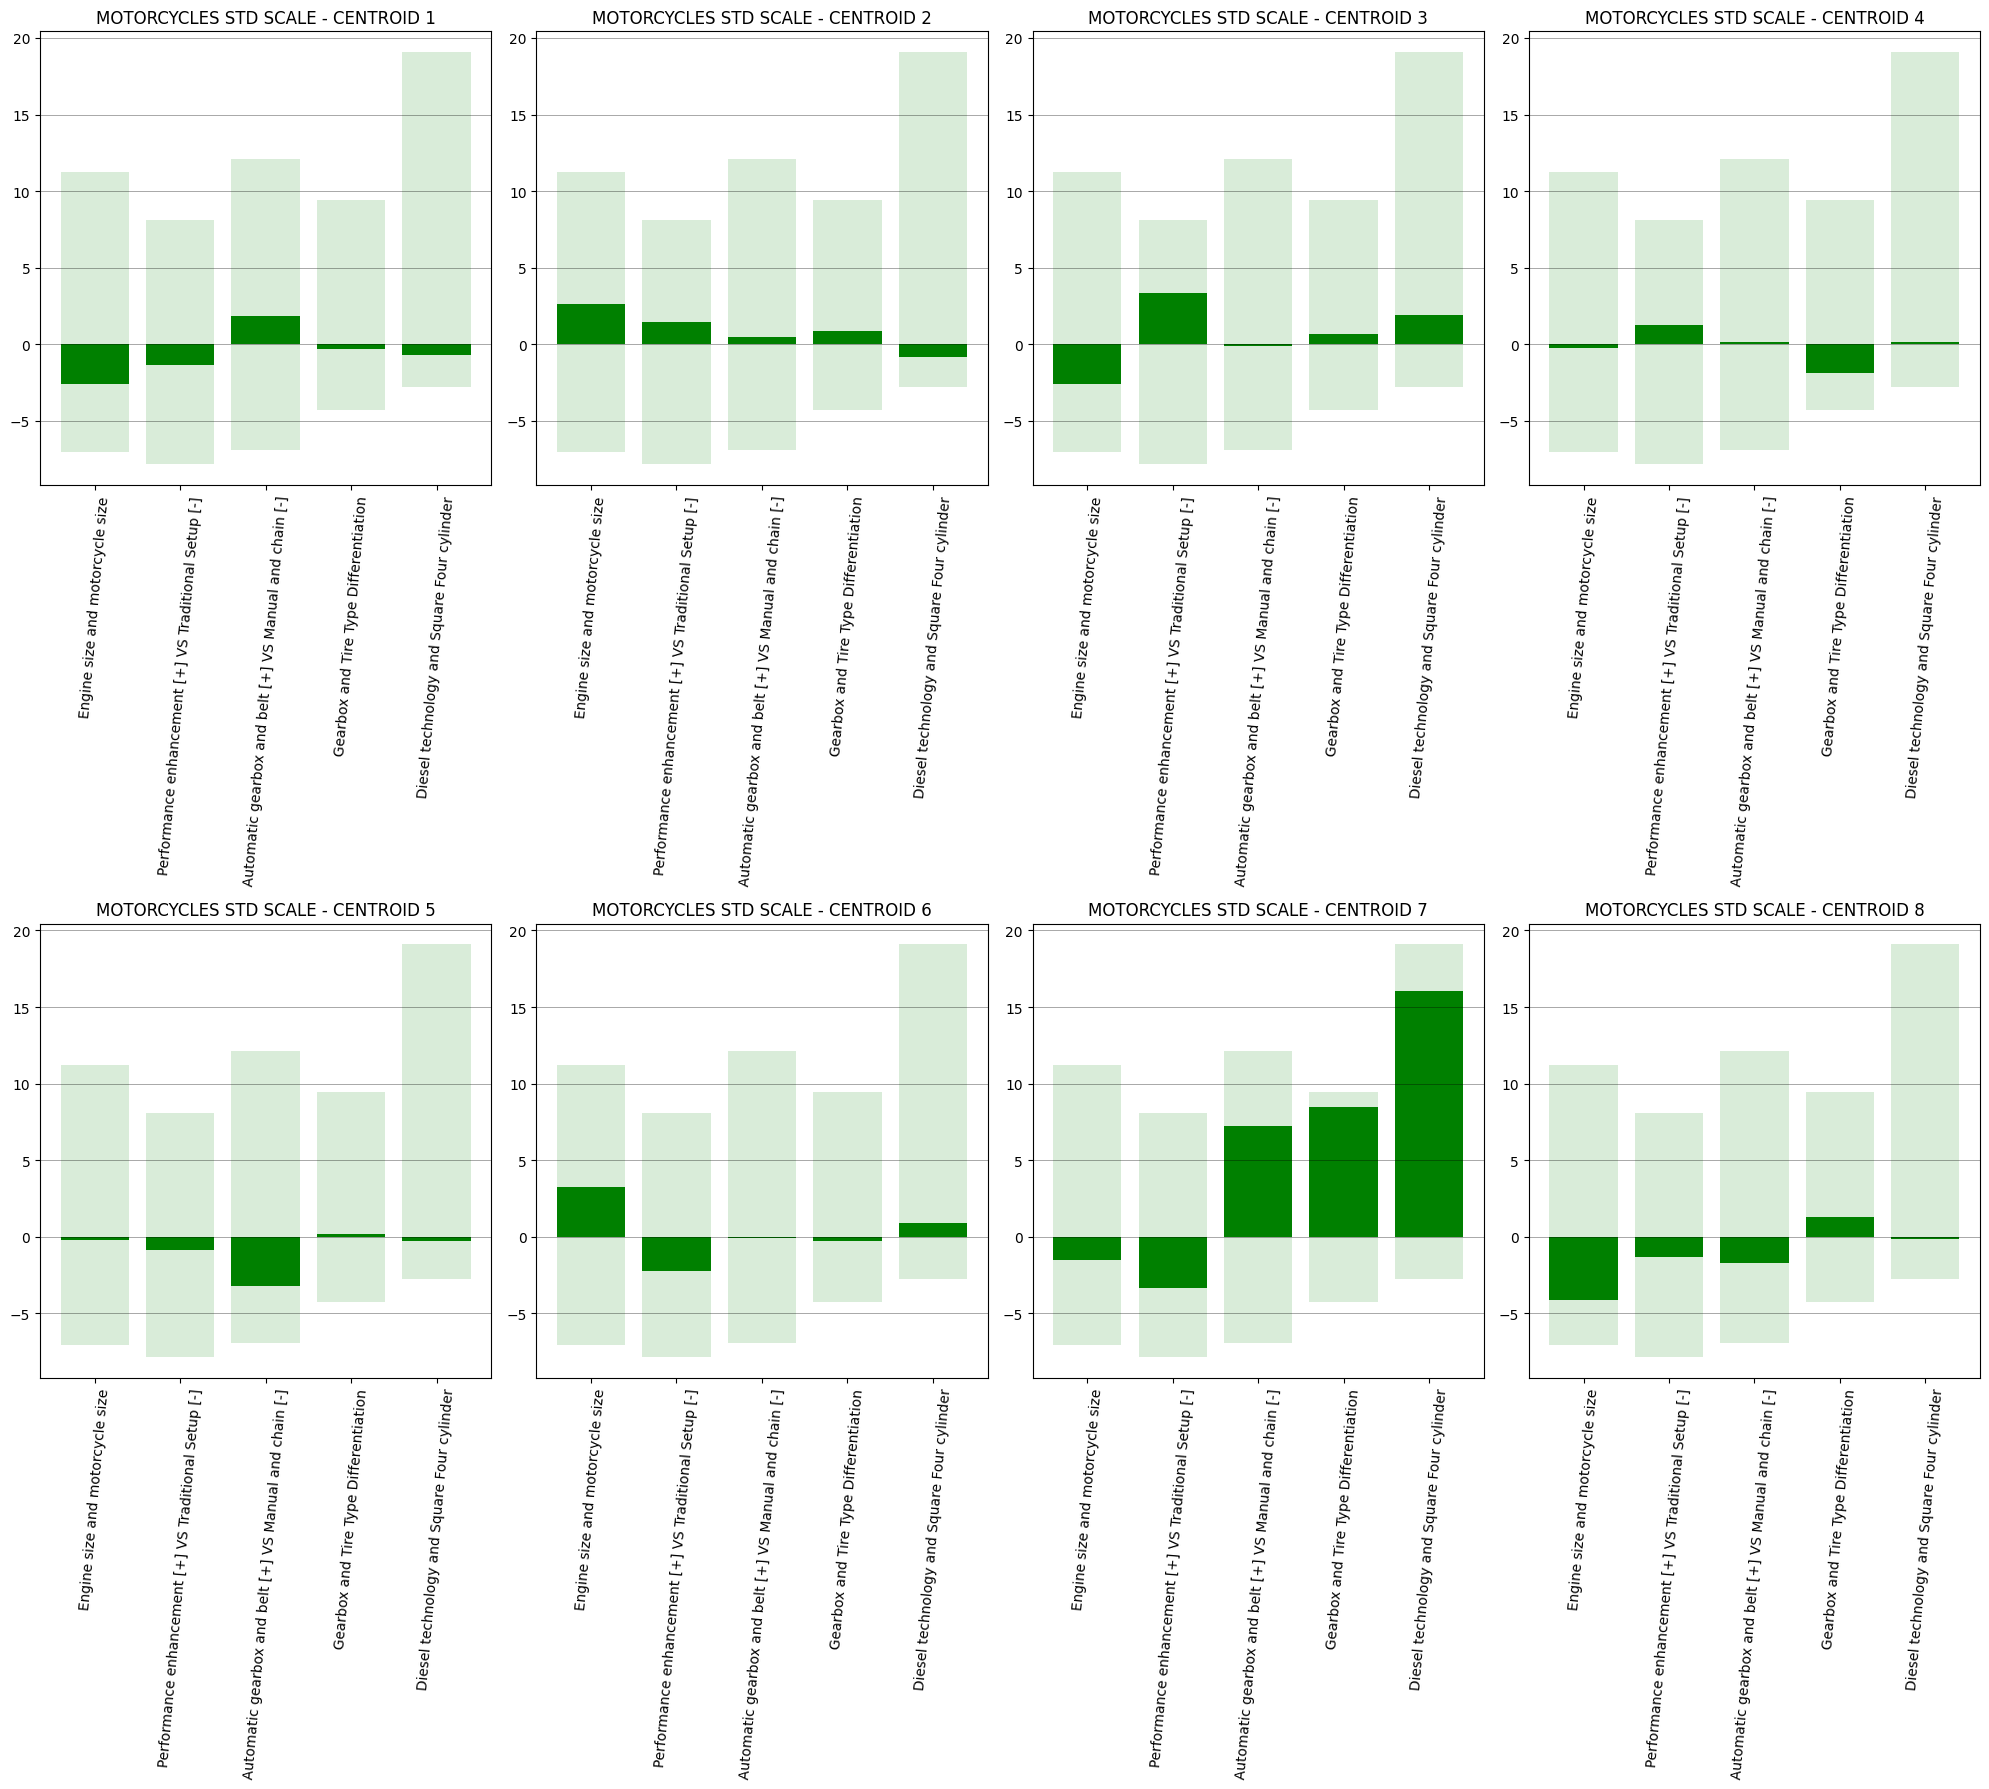

In [80]:
# PLOT THE CONTRIBUTION OF EACH PC IN THE 8 CENTROIDS
# compute the max/min values in the PC-space
max_y_std = Ystd_df.max(axis=0)
min_y_std = Ystd_df.min(axis=0)

n_rows = 2
n_cols = 4
n_plots = n_rows * n_cols

# MAKE THE BARPLOTS OF THE CENTROIDS
fig_centroids, ax_centroids = plt.subplots(n_rows, n_cols, figsize=(20, 18))
for i in range(k_std):
    r = i //n_cols
    c = i %n_cols
    ax = ax_centroids[r, c]

    ax.bar(np.arange(centroids_std.shape[1]), max_y_std, color='green', alpha=0.15)
    ax.bar(np.arange(centroids_std.shape[1]), min_y_std, color='green', alpha=0.15)
    ax.bar(np.arange(centroids_std.shape[1]), centroids_std[i, :], color= 'green')
    ax.set_xticks(ticks=np.arange(centroids_std.shape[1]))
    ax.set_xticklabels(labels=pc_std_names, rotation=85)
    ax.grid(True, axis='y', linewidth=0.4, alpha = 0.6)

    ax.set_title(f'MOTORCYCLES STD SCALE - CENTROID {i+1}')
plt.tight_layout()
plt.show()

***CENTROIDS NAMES***
1. **Centroid 1**: it represents the cluster of **ENDURO/OFFROAD** having relatively small dimensions and traditional setup
2. **Centroid 2**: it represents a hybrid cluster, made of **NAKED BIKES**, but also some features of **SPORT** and **SUPER MOTARD**
3. **Centroid 3**: is also the centre of a heterogeneous group, where both **ENDURO/OFFROAD** and **SUPER MOTARD** models are in
4. **Centroid 4**: it represents the cluster of **ENDURO** and **SUPER MOTARD**, having some feature values in common with cluster 3
5. **Centroid 5**: it represents mainly  **ATVs** and some **SCOOTERS**, those of bigger dimensions
6. **Centroid 6**: is the centre of the cluster of **CUSTOM / CRUISER** mostly
7. **Centroid 7**: characterizes the motorcycles with automatic gearbox and belt transmissions, and diesel technology in bOth stroke and engine. In our data these are some **ALLROUNDs**
8. **Centroid 8**: it represents medium size **SCOOTER**, having small dimensions and traditional setup.

In [81]:
centroids_std_names =['ENDURO/OFFROAD', 'NAKED BIKES+SPORT', 'ENDURO/OFFROAD+SUPER MOTARD', 'ENDURO+SUPER MOTARD', 'ATV+SCOOTERS', 'CUSTOM/CRUISER', 'ALLROUND', 'SCOOTER']

#### Min-Max Scaled Dataframe

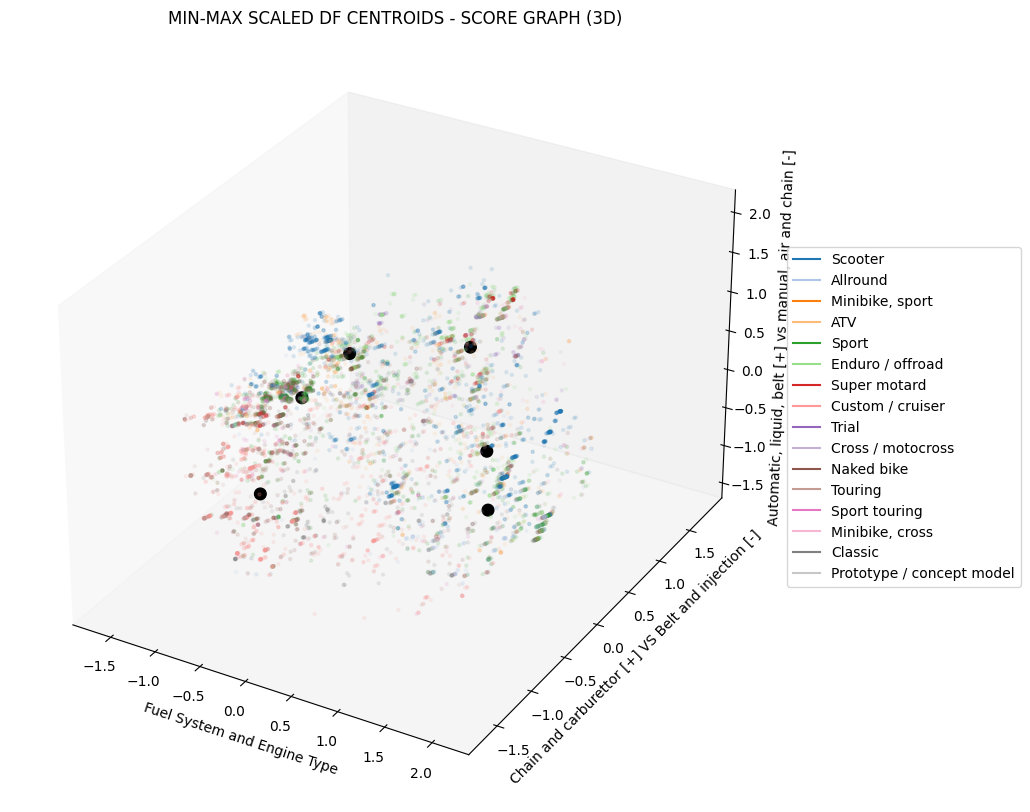

In [82]:
# MAKE THE 3D SCORE GRAPH WITH THE CENTROIDS. MIN-MAX SCALED DF
# Retrieve the K-means model for k=6 (km_mm), extracting centroids to plot
centroids_mm = km_mm.cluster_centers_
#print(centroids_mm)

sg_mm_km = plt.figure(figsize=(10, 10))
ax_sg_mm_km = sg_mm_km.add_subplot(111, projection='3d')
ax_sg_mm_km.scatter(Ymm_df[:, 0], Ymm_df[:, 1], Ymm_df[:, 2], s=5, c=LabelsDF['Category Color'].values, alpha=0.10 )
ax_sg_mm_km.scatter(centroids_mm[:, 0], centroids_mm[:, 1], centroids_mm[:, 2], s=70, c='black', alpha=1 )
ax_sg_mm_km.set_box_aspect((1, 1.2, 0.8))

plt.title('MIN-MAX SCALED DF CENTROIDS - SCORE GRAPH (3D)')
ax_sg_mm_km.set_xlabel(pc_mm_names[0])
ax_sg_mm_km.set_ylabel(pc_mm_names[1])
ax_sg_mm_km.set_zlabel(pc_mm_names[2])

#Move the legend outside the graph
legend = plt.legend(categories_colors_legend, [k for k in categories_colors.keys()], loc='center left', bbox_to_anchor=(1, 0.5))
ax_sg_mm_km.grid(False)
plt.show()

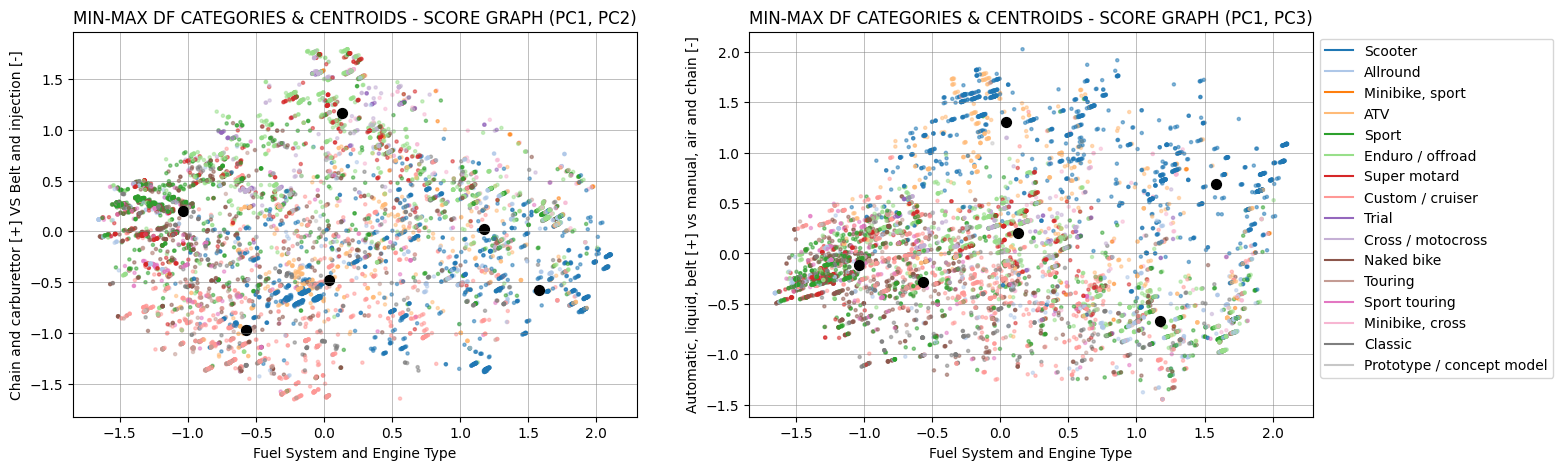

In [83]:
fig2, axes = plt.subplots(1,2)
fig2.set_size_inches(16,5)

#PRINCIPAL COMPONENTS 1 AND 2
axes[0].scatter(Ymm_df[:, 0], Ymm_df[:, 1], s=5, c=LabelsDF['Category Color'].values, alpha=0.5)
axes[0].scatter(centroids_mm[:, 0], centroids_mm[:, 1], s=50, c='black', alpha=1)
axes[0].set_title('MIN-MAX DF CATEGORIES & CENTROIDS - SCORE GRAPH (PC1, PC2)')
axes[0].set_xlabel(pc_mm_names[0])
axes[0].set_ylabel(pc_mm_names[1])
axes[0].grid(True, color = 'gray', linewidth = 0.6, alpha = 0.6)

#PRINCIPAL COMPONENTS 1 AND 3
axes[1].scatter(Ymm_df[:, 0], Ymm_df[:, 2], s=5, c=LabelsDF['Category Color'].values, alpha=0.5)
axes[1].scatter(centroids_mm[:, 0], centroids_mm[:, 2], s=50, c='black', alpha=1)
axes[1].set_title('MIN-MAX DF CATEGORIES & CENTROIDS - SCORE GRAPH (PC1, PC3)')
axes[1].set_xlabel(pc_mm_names[0])
axes[1].set_ylabel(pc_mm_names[2])
legend = plt.legend(categories_colors_legend, [k for k in categories_colors.keys()], loc='upper left', bbox_to_anchor=(1, 1))
axes[1].grid(True, color = 'gray', linewidth = 0.6, alpha = 0.6)

plt.show()

Due to the large number of possible categories of motorbikes, we also illustrate the graph with a reduced number of these (6), chosen by looking at the full graph.

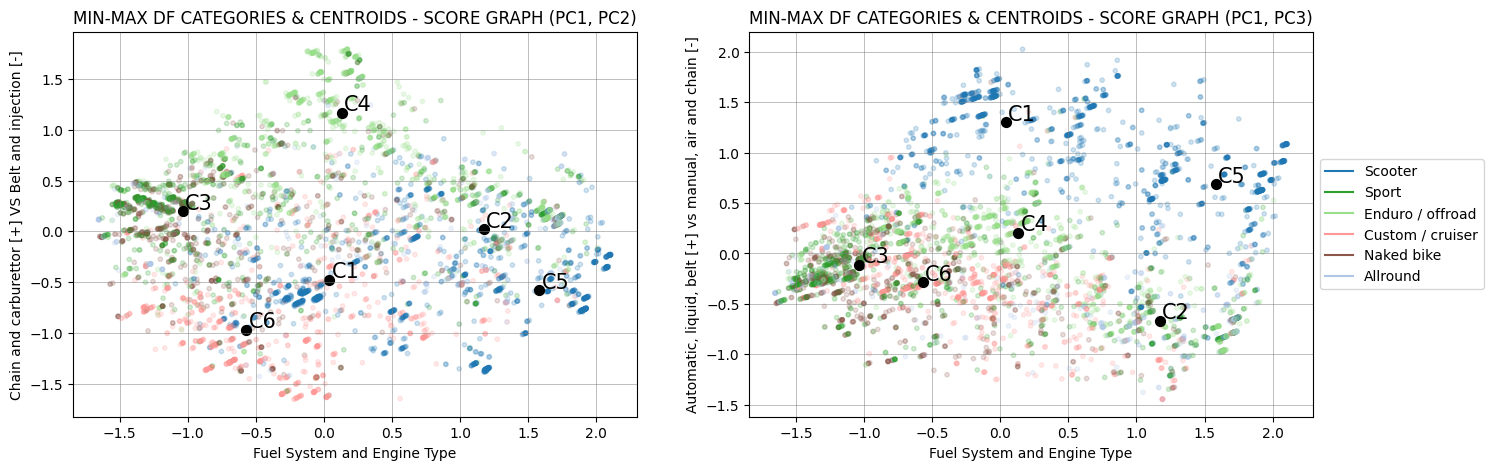

In [89]:
# Select the desired categories to plot
selected_categories = ['Scooter', 'Sport', 'Enduro / offroad', 'Custom / cruiser', 'Naked bike', 'Allround']  #'Super motard', 'ATV']
#selected_categories = ['Allround']

# Filter the data based on the selected categories
filtered_Ymm_df = Ymm_df[LabelsDF['Category'].isin(selected_categories)]
filtered_colors = LabelsDF[LabelsDF['Category'].isin(selected_categories)]

# Extract a new dictionary for selected categories
selected_colors = {category: categories_colors[category] for category in selected_categories}

fig2, axes = plt.subplots(1,2)
fig2.set_size_inches(16,5)

#PRINCIPAL COMPONENTS 1 AND 2
axes[0].scatter(filtered_Ymm_df[:, 0], filtered_Ymm_df[:, 1], s=10, c=filtered_colors['Category Color'].values, alpha=0.2)
axes[0].scatter(centroids_mm[:, 0], centroids_mm[:, 1], s=50, c='black', alpha=1)
axes[0].set_title('MIN-MAX DF CATEGORIES & CENTROIDS - SCORE GRAPH (PC1, PC2)')
axes[0].set_xlabel(pc_mm_names[0])
axes[0].set_ylabel(pc_mm_names[1])
axes[0].grid(True, color = 'gray', linewidth = 0.6, alpha = 0.6)

#Add labels to centroids
for xi, yi, text in zip(centroids_mm[:,0], centroids_mm[:,1], notes):
    axes[0].annotate(text,
                 xy = (xi, yi), xycoords='data',
                 xytext=(1.5,1.5), textcoords='offset points',
                 color='black', fontsize=15)

#PRINCIPAL COMPONENTS 1 AND 3
axes[1].scatter(filtered_Ymm_df[:, 0], filtered_Ymm_df[:, 2], s=10, c=filtered_colors['Category Color'].values, alpha=0.2)
axes[1].scatter(centroids_mm[:, 0], centroids_mm[:, 2], s=50, c='black', alpha=1)
axes[1].set_title('MIN-MAX DF CATEGORIES & CENTROIDS - SCORE GRAPH (PC1, PC3)')
axes[1].set_xlabel(pc_mm_names[0])
axes[1].set_ylabel(pc_mm_names[2])

#Add labels to centroids
for xi, yi, text in zip(centroids_mm[:,0], centroids_mm[:,2], notes):
    axes[1].annotate(text,
                 xy = (xi, yi), xycoords='data',
                 xytext=(1.5,1.5), textcoords='offset points',
                 color='black', fontsize=15)


# Add legend of the filtered categories
legend_elements = [Line2D([0], [0], color=selected_colors[category], label=category) for category in selected_categories]
legend = plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))

axes[1].grid(True, color = 'gray', linewidth = 0.6, alpha = 0.6)

plt.show()

**Centroid Contribution Plot, Min-Max Scaled DF**.
The code snippet below gives 6 barplots, one for each centroid founded for the ***Min-Max** dataframe.

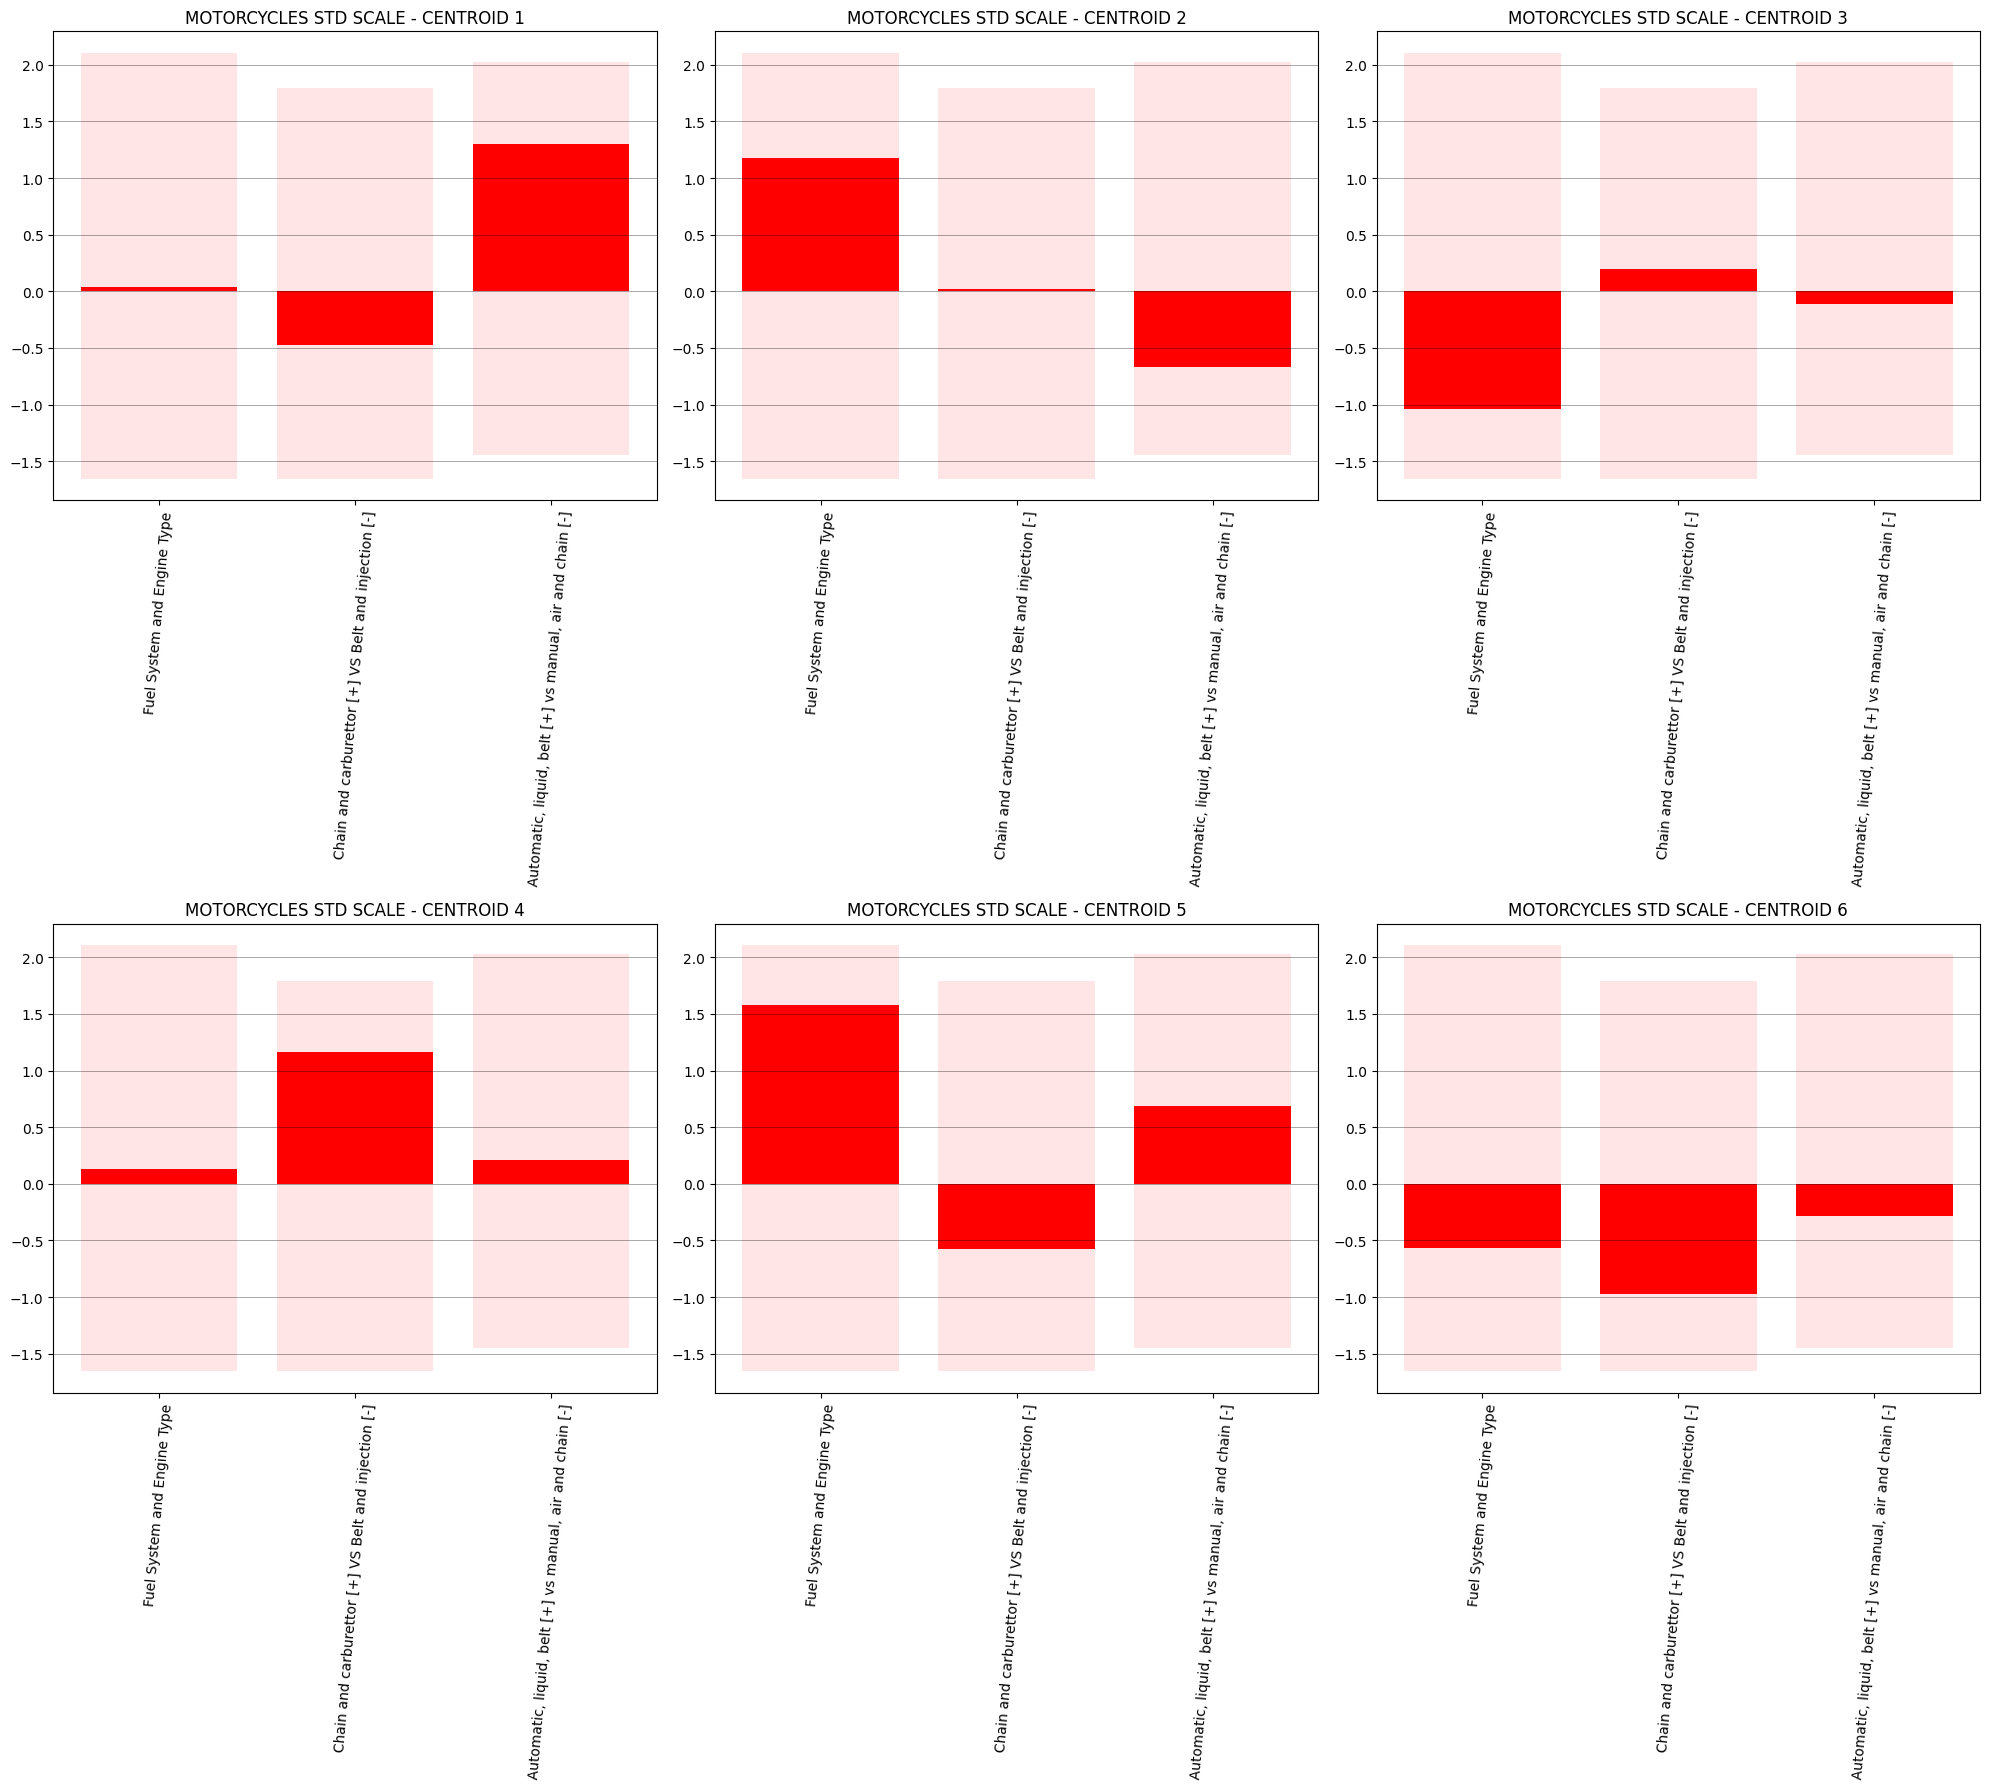

In [86]:
# PLOT THE CONTRIBUTION OF EACH PC IN THE 6 CENTROIDS
# compute the max/min values in the PC-space
max_y_mm = Ymm_df.max(axis=0)
min_y_mm = Ymm_df.min(axis=0)

n_rows = 2
n_cols = 3
n_plots = n_rows * n_cols

# MAKE THE BARPLOTS OF THE CENTROIDS
fig_centroids, ax_centroids = plt.subplots(n_rows, n_cols, figsize=(20, 18))
for i in range(k_mm):
    r = i //n_cols
    c = i %n_cols
    ax = ax_centroids[r, c]

    ax.bar(np.arange(centroids_mm.shape[1]), max_y_mm, color='red', alpha=0.1)
    ax.bar(np.arange(centroids_mm.shape[1]), min_y_mm, color='red', alpha=0.1)
    ax.bar(np.arange(centroids_mm.shape[1]), centroids_mm[i, :], color= 'red')
    ax.set_xticks(ticks=np.arange(centroids_mm.shape[1]))
    ax.set_xticklabels(labels=pc_mm_names, rotation=85)
    ax.grid(True, axis='y', linewidth=0.4, alpha = 0.6)

    ax.set_title(f'MOTORCYCLES STD SCALE - CENTROID {i+1}')
plt.tight_layout()
plt.show()

***CENTROIDS NAMES***
The interpretation of the centroids is not that easy, since a lot of categories overlap and differences between the motorbikes are not so evident. Anyway, we try to give a meaning to the clusters found, also by plotting the various categories individually.
1. **Centroid 1**: it represents a cluster of **SCOOTERS**, being these usually automatic, with belt and injection system.
2. **Centroid 2**: it represents mostly **ALLROUND** bikes but has some features in common with **SPORT** or **ENDURO/OFFROAD** ones.
3. **Centroid 3**: it represents **NAKED BIKE** with some observations of **SPORT** and **SUPER MOTARD**
4. **Centroid 4**: it represents **ENDURO/OFFROAD** motorcycles, together with centroid 2
5. **Centroid 5**: it represents the cluster of **SCOOTERS**, in particular those made with traditional fuel systems and engine.
6. **Centroid 6**: it represents the cluster of **CUSTOM / CRUISER**, having modern and advanced technology, with manual gearbox.

In [88]:
centroids_mm_names =['SCOOTERS', 'ALLROUND+SPORT', 'NAKED BIKE+SUPER MOTARD', 'ENDURO/OFFROAD', 'SCOOTERS', 'CUSTOM/CRUISER']